In [3]:
import datetime, os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(32, 24), dpi=80)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import contingency_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
mlp = MLPClassifier(max_iter=500)
#from sklearn.inspection import DecisionBoundaryDisplay

<Figure size 2560x1920 with 0 Axes>

# Import Data and Configure Labels 

In [7]:
#Hosted Root file
ROOT = '/content/drive/MyDrive/Ian Helman/Classes/EE5821/Final Project/Data/';
#Local Root File
#ROOT = 'C:/Users/idhelman/Data/'
#Read all data from csv
df = pd.read_excel(ROOT + 'mtb_stats_1.xlsx', sheet_name = 1, usecols = "A,B,I:Q,U:X")
print(df.isna().sum().sum())
#aMake dummy DF for labels
df_dummy = pd.get_dummies(df.loc[:,'label'])
#Make indexes the same before concat
df_dummy.index = df.index
#Merge the dfs together so that the new labels are easily accessible
df_ml = pd.concat([df, df_dummy], axis=1)
#DF with no Nans
df_nona = df.dropna()
df_ml_nona = df_ml.dropna()
#Single Label Multi Class (Delete NaNs)
le = LabelEncoder()
y_delete_NaN = le.fit_transform(df_nona.loc[:,'label'])

89


In [ ]:
#Fill Nans with Means of each Label
df["f_piston"].fillna(df.groupby("label")["f_piston"].transform("mean"),inplace=True)
df["f_rotor_dim"].fillna(df.groupby("label")["f_rotor_dim"].transform("mean"),inplace=True)
df["r_piston"].fillna(df.groupby("label")["r_piston"].transform("mean"),inplace=True)
df["r_rotor_dim"].fillna(df.groupby("label")["r_rotor_dim"].transform("mean"),inplace=True)
df["reach"].fillna(df.groupby("label")["reach"].transform("mean"),inplace=True)
df["stack"].fillna(df.groupby("label")["stack"].transform("mean"),inplace=True)
df["wheelbase"].fillna(df.groupby("label")["wheelbase"].transform("mean"),inplace=True)
df["chainstay_length"].fillna(df.groupby("label")["chainstay_length"].transform("mean"),inplace=True)
#Check for existence of NaNs
df.isnull().sum().sum()
#Single Label Multi Class
le = LabelEncoder()
y_mean_NaN = le.fit_transform(df.loc[:,'label'])
dict(zip(le.classes_,range(len(le.classes_))))
print(len(df.index))

154


In [ ]:
df.head()

,model,brand,label,rear_travel,fork_travel,f_piston,f_rotor_dim,r_piston,r_rotor_dim,head_angle,seat_angle,reach,stack,wheelbase,chainstay_length
0,habit,cannondale,Tr,130,140,4.0,180.0,4.0,180.0,66.0,74.5,460.0,625.0,1210.0,435.0
1,scalpel,cannondale,Xc,100,100,2.0,160.0,2.0,160.0,68.0,74.5,435.0,601.0,1175.0,436.0
2,scalpel se,cannondale,Dc,120,120,2.0,160.0,2.0,160.0,67.0,74.0,450.0,611.0,1172.0,436.0
3,reign advanced pro,giant,En,146,170,4.0,203.0,4.0,203.0,64.6,76.4,488.0,631.0,1262.0,439.0
4,trance advanced X pro,giant,Tr,135,150,4.0,203.0,4.0,180.0,66.2,77.9,494.0,624.0,1238.0,435.0


# EDA

Tr    52
En    44
Xc    19
Dc    15
Am    12
Dh    12
Name: label, dtype: int64


ValueError: ignored

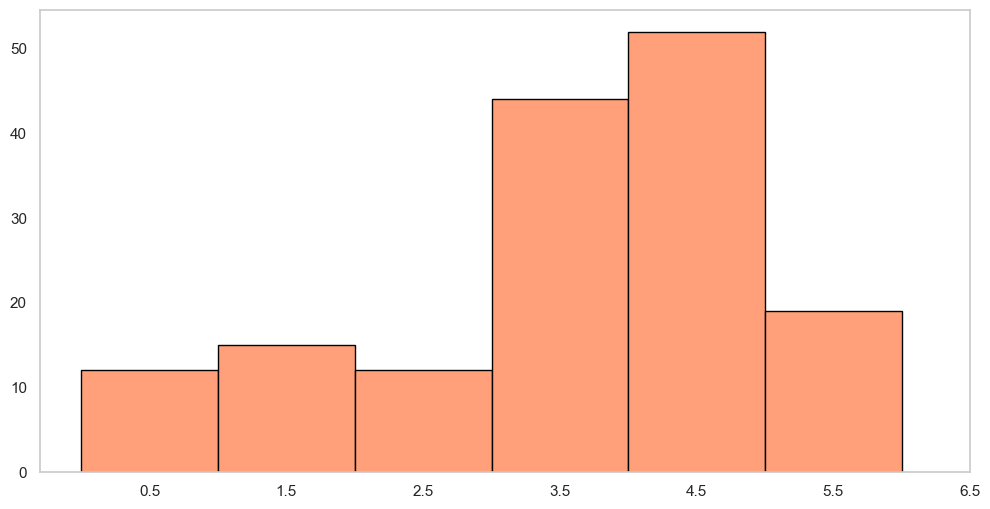

In [ ]:
# Histogram of Labels
print(df['label'].value_counts())
x_ticks_labels = ['AM','DC','DH','EN','TR','XC']
plt.rcParams["figure.figsize"] = [12,6]
fig1, ax1 = plt.subplots()
bin = np.arange(7)
n, bins, patches = ax1.hist(x = y_mean_NaN, bins = bin, facecolor='lightsalmon',edgecolor='black');
ax1.set_xticks(bin+.5);
ax1.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)
ax1.set_title('Number of MTBs per Category')
ax1.set_ylabel('Counts')

In [ ]:
#Pairplot
#sns.pairplot(df, hue="label", diag_kind="hist")

Text(0.5, 1.0, 'Mountain Bike Feature Correlation')

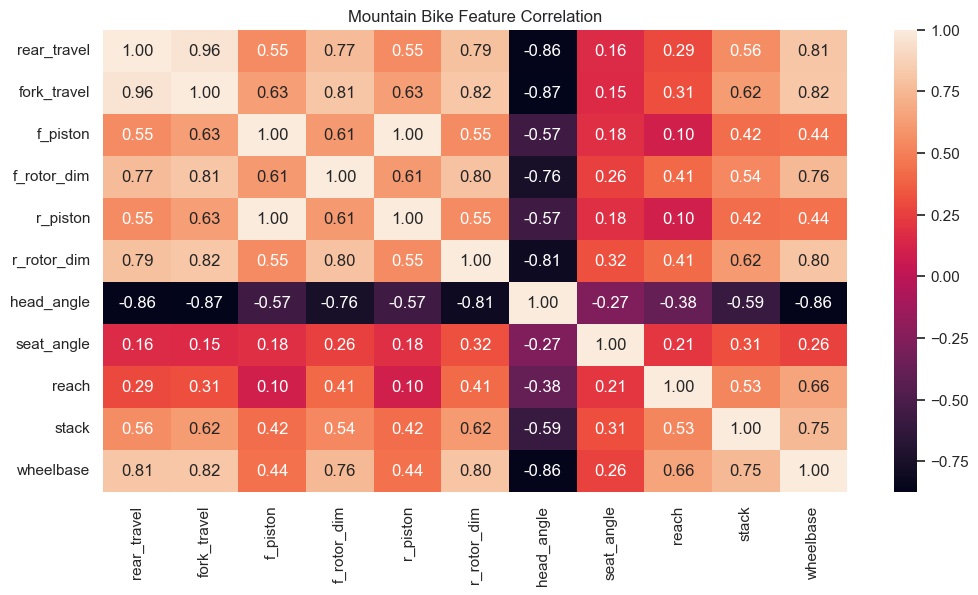

In [ ]:
#Correlation Plot
sns.heatmap(df.iloc[:,3:-1].corr(), annot=True, fmt='.2f')
plt.title("Mountain Bike Feature Correlation")

# PCA

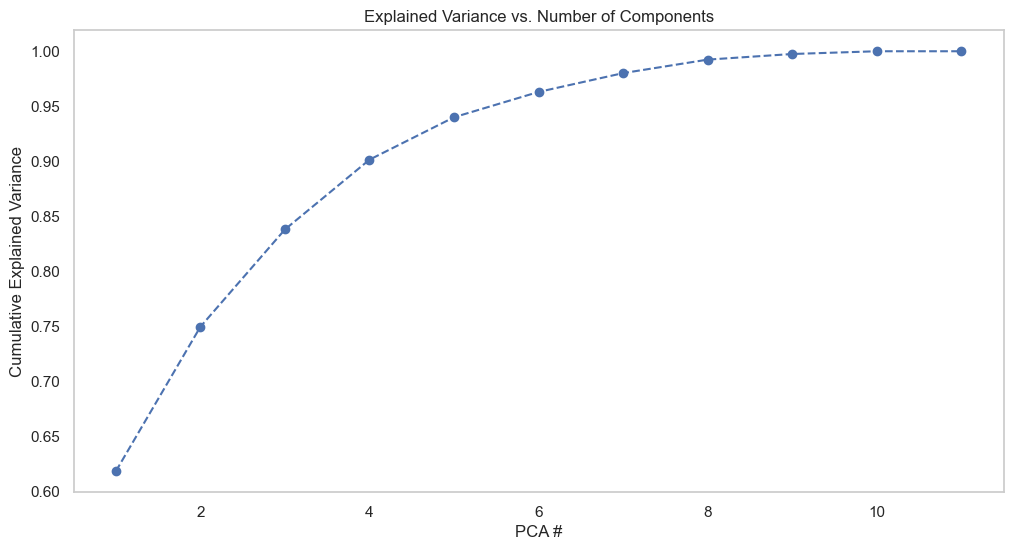

In [ ]:
#Fit standard scaler
scaler = StandardScaler();
df_std = scaler.fit_transform(df.iloc[:,3:-1]);
#Fit PCA
pca = PCA()
pca.fit(df_std)
#Check variance ratio for number of components
pca.explained_variance_ratio_
plt.plot(range(1,12),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('PCA #')
plt.ylabel('Cumulative Explained Variance')

#Use 80% variance # components (3)
pca = PCA(n_components = 3)
pca.fit(df_std)
pca.transform(df_std)
scores_pca = pca.transform(df_std)

# KMeans


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory le

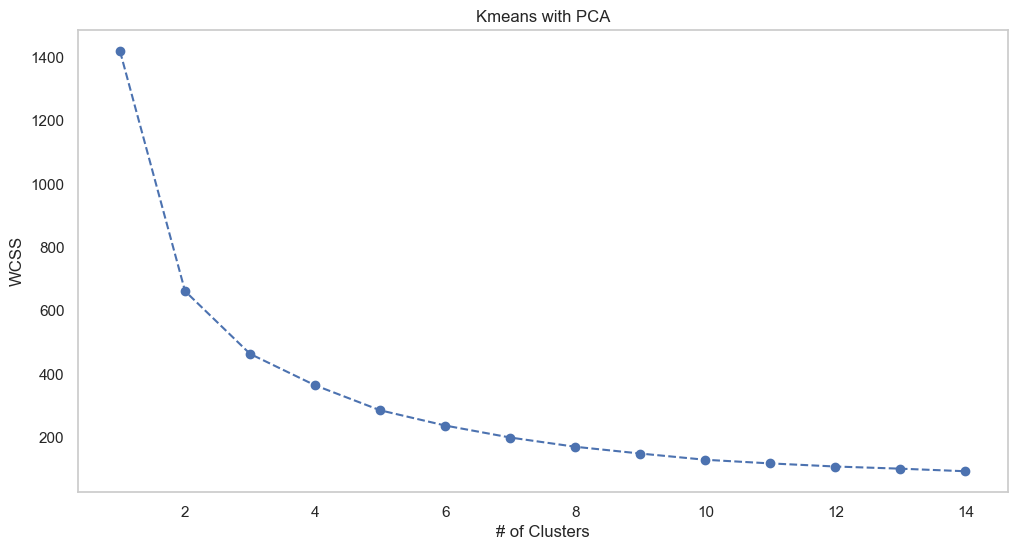

In [ ]:
inert = []
#Kmeans with pca for loop
for i in range (1,15):
  kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 1)
  kmeans_pca.fit(scores_pca)
  inert.append(kmeans_pca.inertia_)

#Plot kmeans performance
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.plot(range(1,15), inert, marker = 'o', linestyle = '--')
plt.xlabel('# of Clusters')
plt.ylabel('WCSS')
plt.title('Kmeans with PCA')
plt.show()

C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


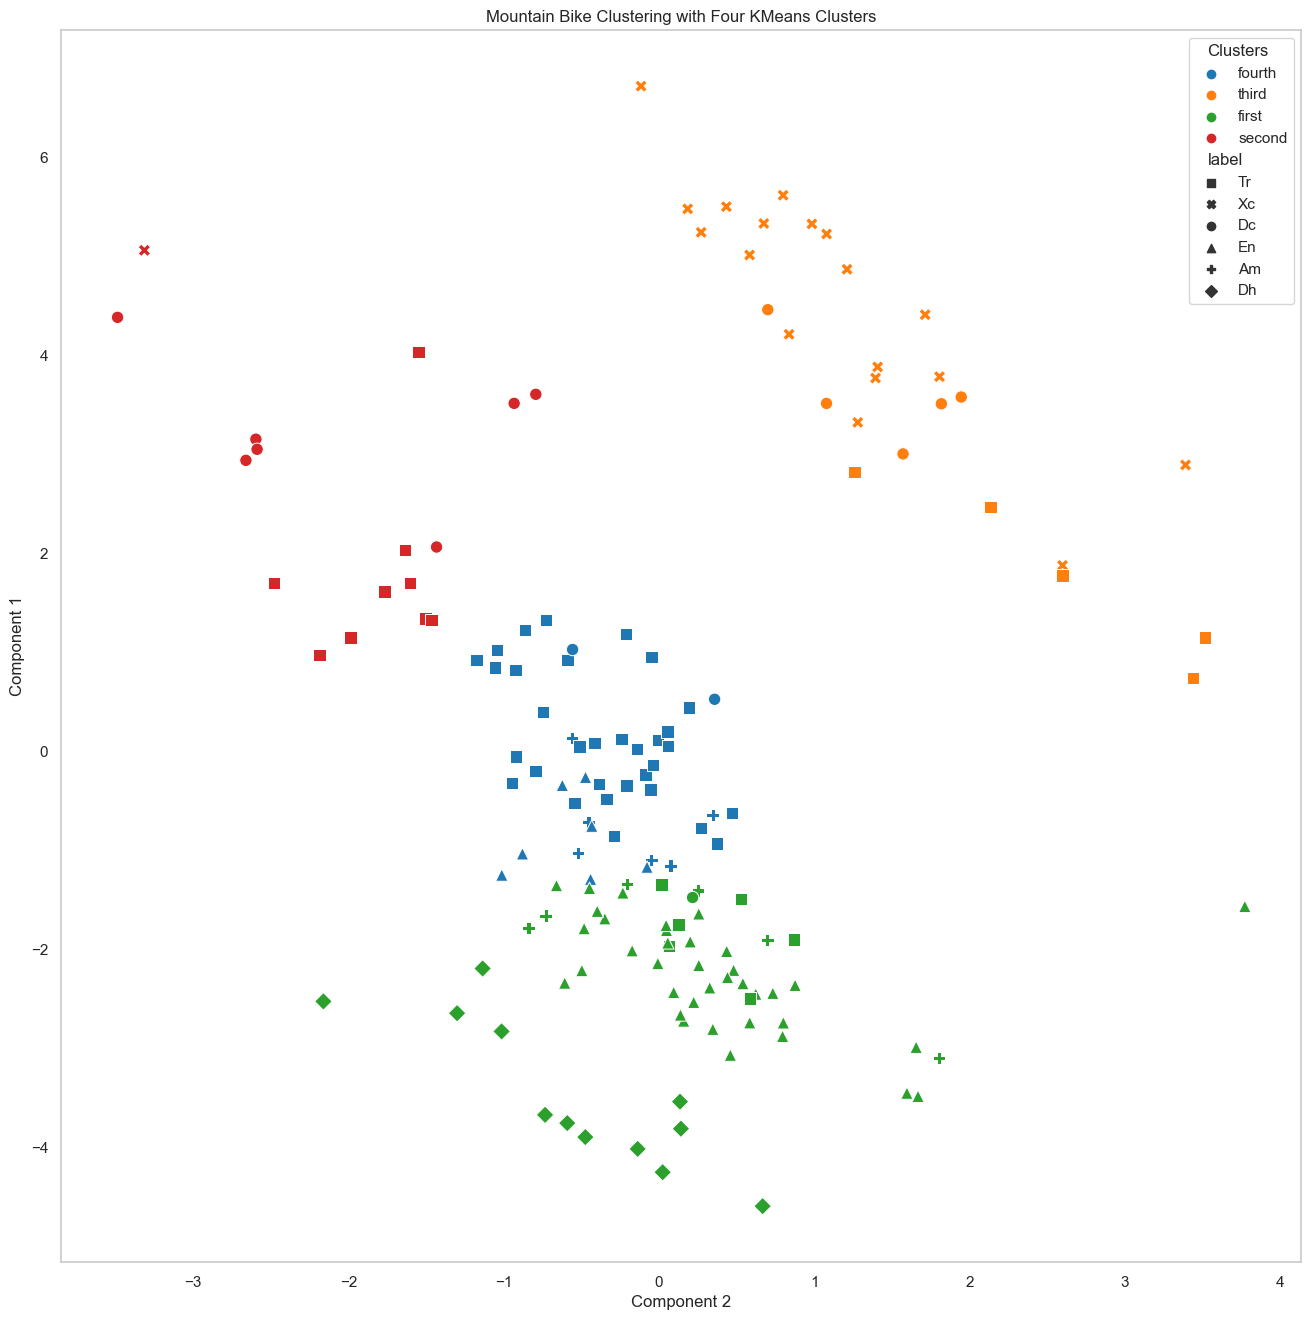

Text(0.5, 1.0, 'Mountain Bike KMeans (4) Contingency Matrix')

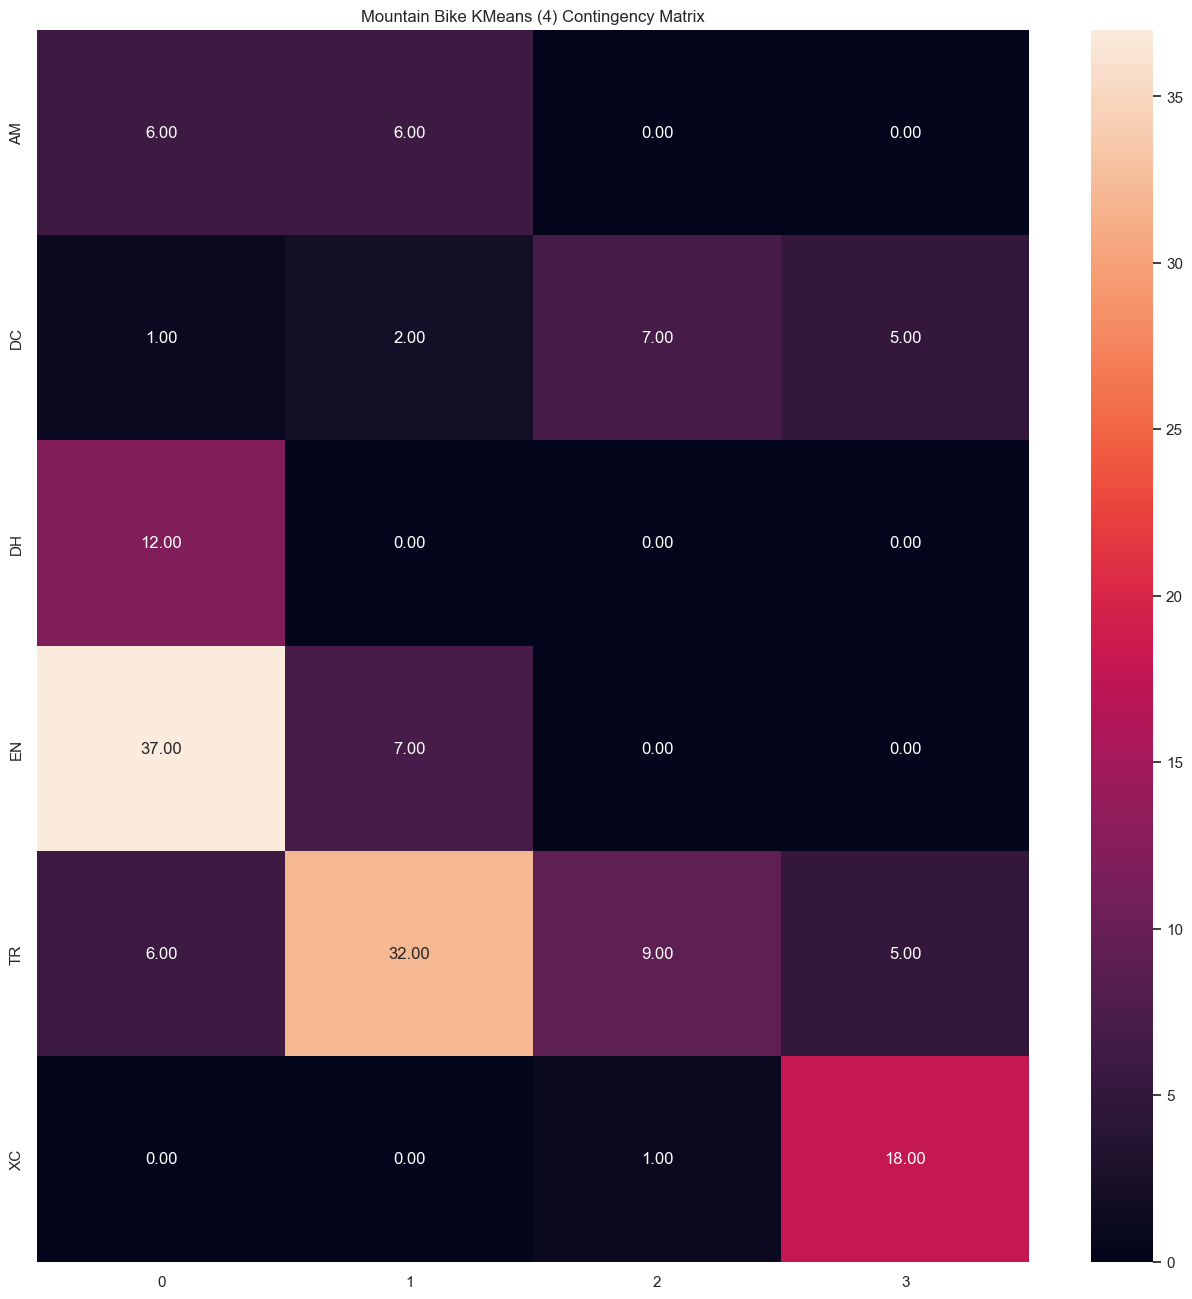

In [ ]:
#Use Four Clusters
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 1)
kmeans_pca.fit(scores_pca)
df_pca_kmeans_4 = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans_4.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_pca_kmeans_4['Segment K-means PCA'] = kmeans_pca.labels_
df_pca_kmeans_4['Clusters'] = df_pca_kmeans_4['Segment K-means PCA'].map({0:'first', 1:'second', 2:'third', 3:'fourth'})

#Plot four clusters
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("whitegrid", {'axes.grid' : False})
map_labels_4 = ['First', 'Second', 'Third', 'Fourth']
palette4 = sns.color_palette("tab10",4)
x_axis = df_pca_kmeans_4['Component 2']
y_axis = df_pca_kmeans_4['Component 1']
markers = {"Tr": "s", "Xc": "X", "Dc": "o", "En":"^", "Am":"P","Dh":"D"}
sns.scatterplot(x = x_axis, y = y_axis, hue = df_pca_kmeans_4['Clusters'], palette = palette4, style = df.loc[:,'label'],s=80, markers = markers)
plt.title("Mountain Bike Clustering with Four KMeans Clusters")
plt.show()

#Contingency Matrix
sns.heatmap(contingency_matrix(df.loc[:,'label'], df_pca_kmeans_4['Clusters']), annot=True, fmt='.2f',yticklabels = x_ticks_labels)
plt.title("Mountain Bike KMeans (4) Contingency Matrix")

C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


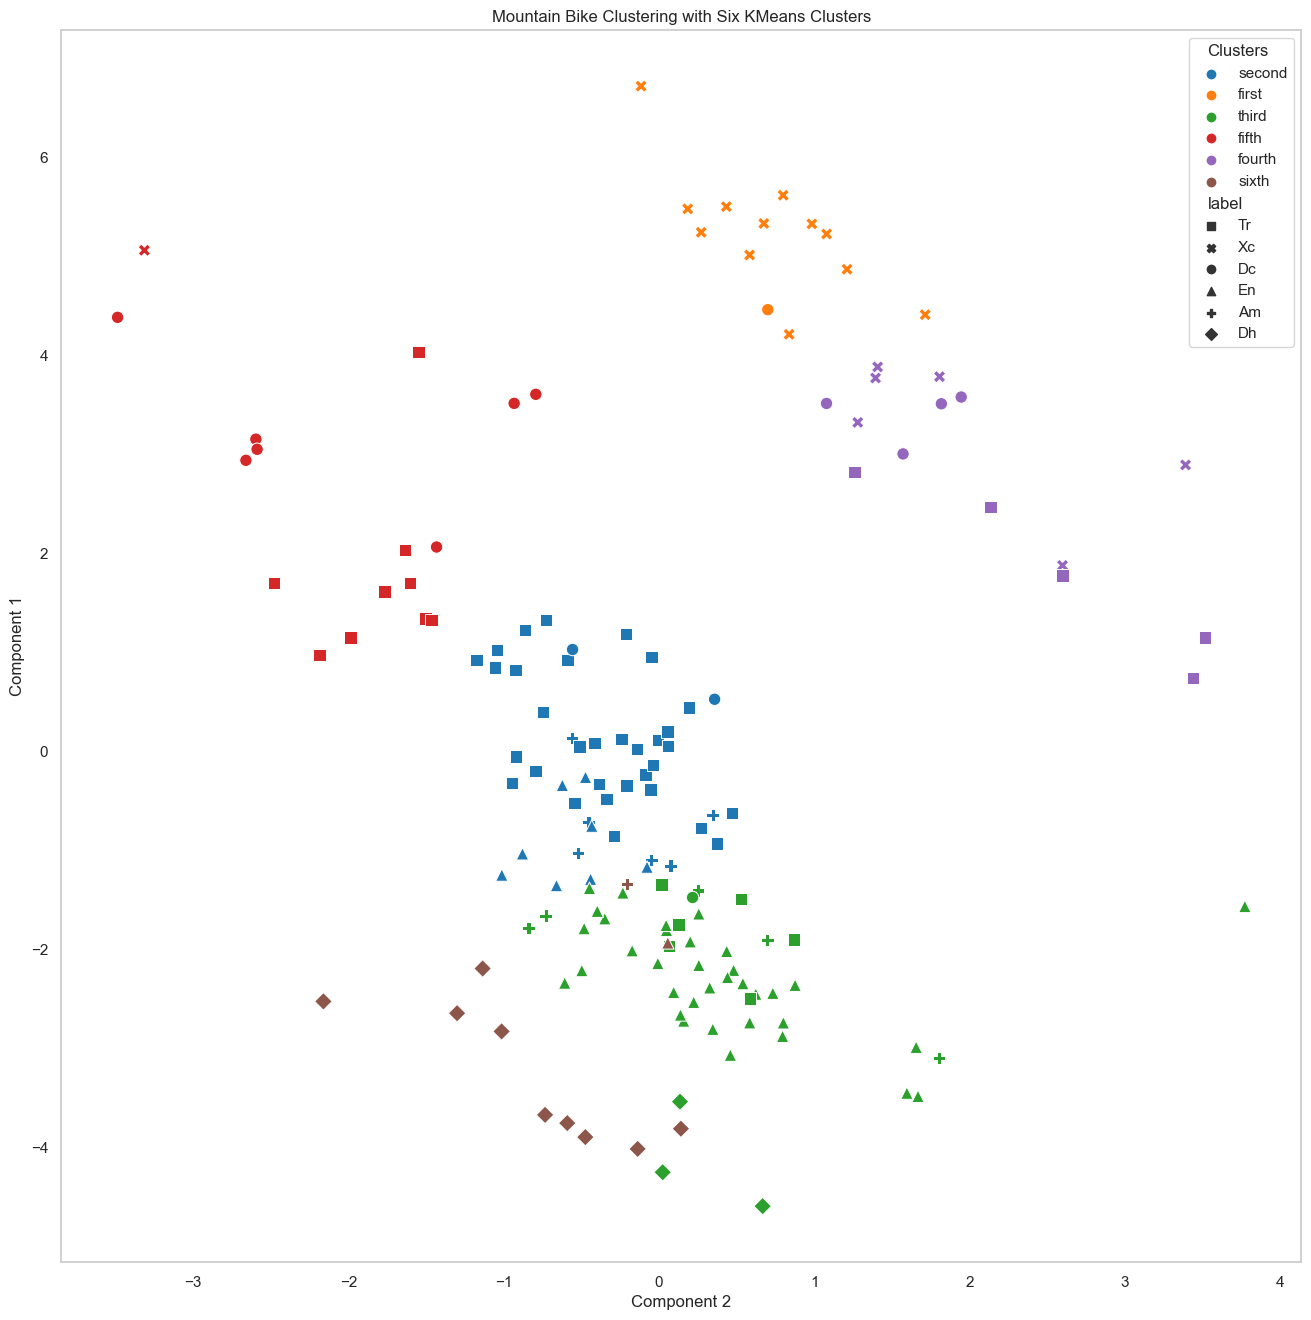

Text(0.5, 1.0, 'Mountain Bike KMeans (6) Contingency Matrix')

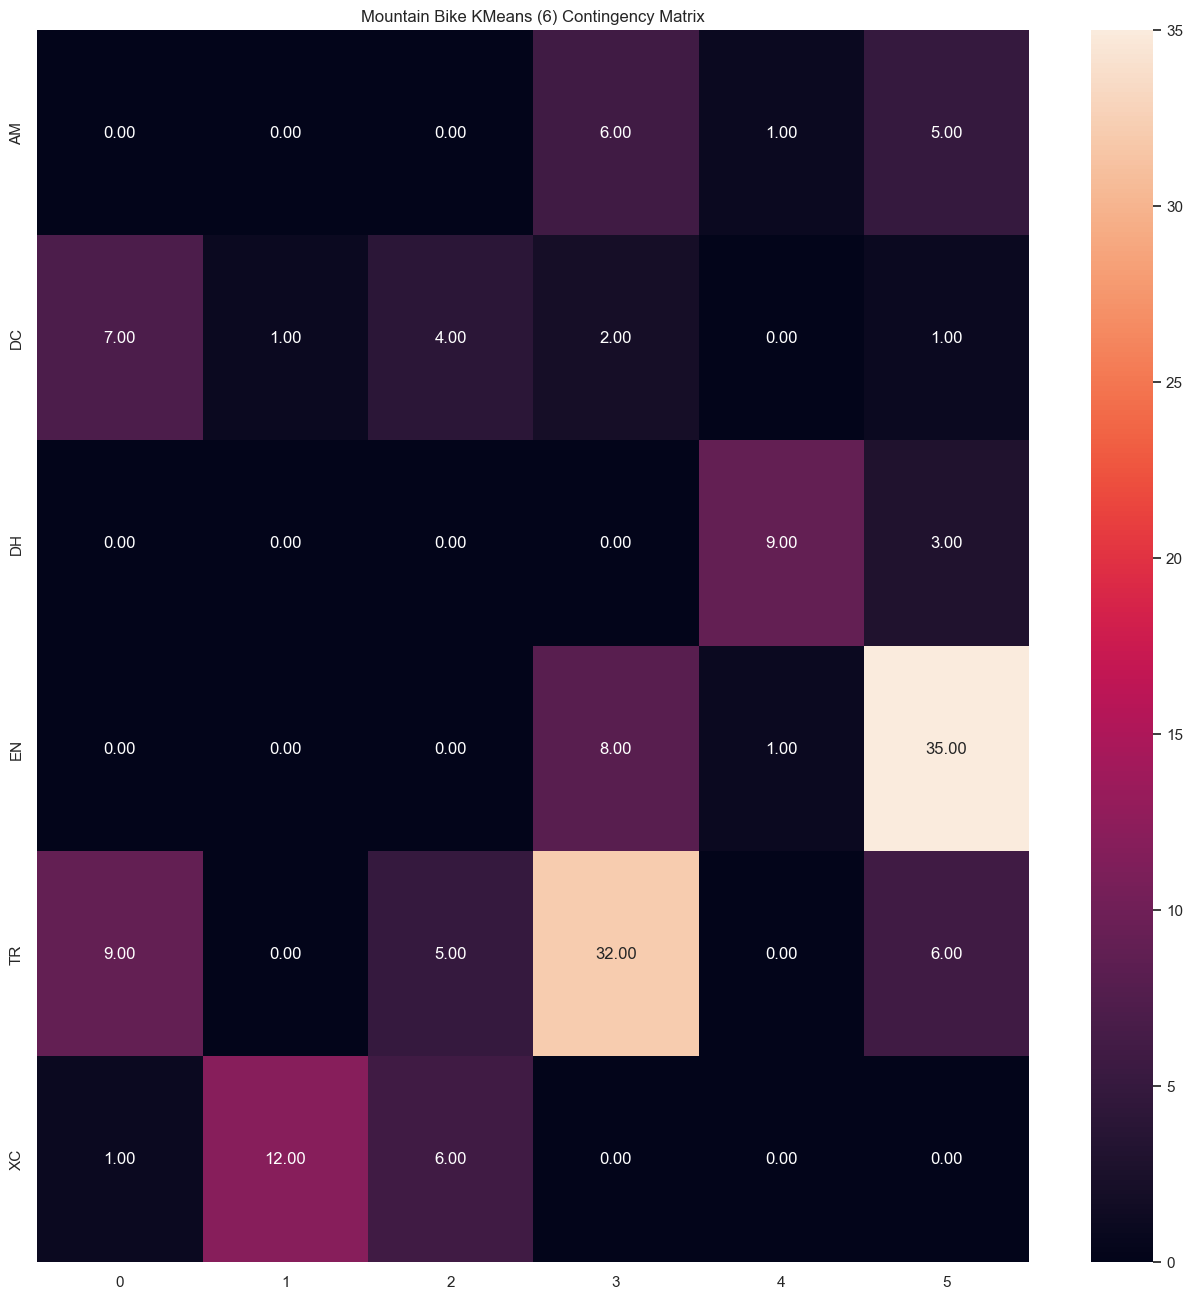

In [ ]:
#Use Six Clusters
kmeans_pca = KMeans(n_clusters = 6, init = 'k-means++', random_state = 1)
kmeans_pca.fit(scores_pca)
df_pca_kmeans_6 = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans_6.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_pca_kmeans_6['Segment K-means PCA'] = kmeans_pca.labels_
df_pca_kmeans_6['Clusters'] = df_pca_kmeans_6['Segment K-means PCA'].map({0:'first', 1:'second', 2:'third', 3:'fourth', 4:'fifth', 5:'sixth'})

#Plot six clusters
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("whitegrid", {'axes.grid' : False})
map_labels_6 = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth']
palette6 = sns.color_palette("tab10",6)
x_axis = df_pca_kmeans_6['Component 2']
y_axis = df_pca_kmeans_6['Component 1']
sns.scatterplot(x = x_axis,y = y_axis, hue = df_pca_kmeans_6['Clusters'], palette = palette6, style = df.loc[:,'label'],s=80, markers = markers)
plt.title("Mountain Bike Clustering with Six KMeans Clusters")
plt.show()

#Contingency Matrix
sns.heatmap(contingency_matrix(df.loc[:,'label'], df_pca_kmeans_6['Clusters']), annot=True, fmt='.2f',yticklabels = x_ticks_labels)
plt.title("Mountain Bike KMeans (6) Contingency Matrix")

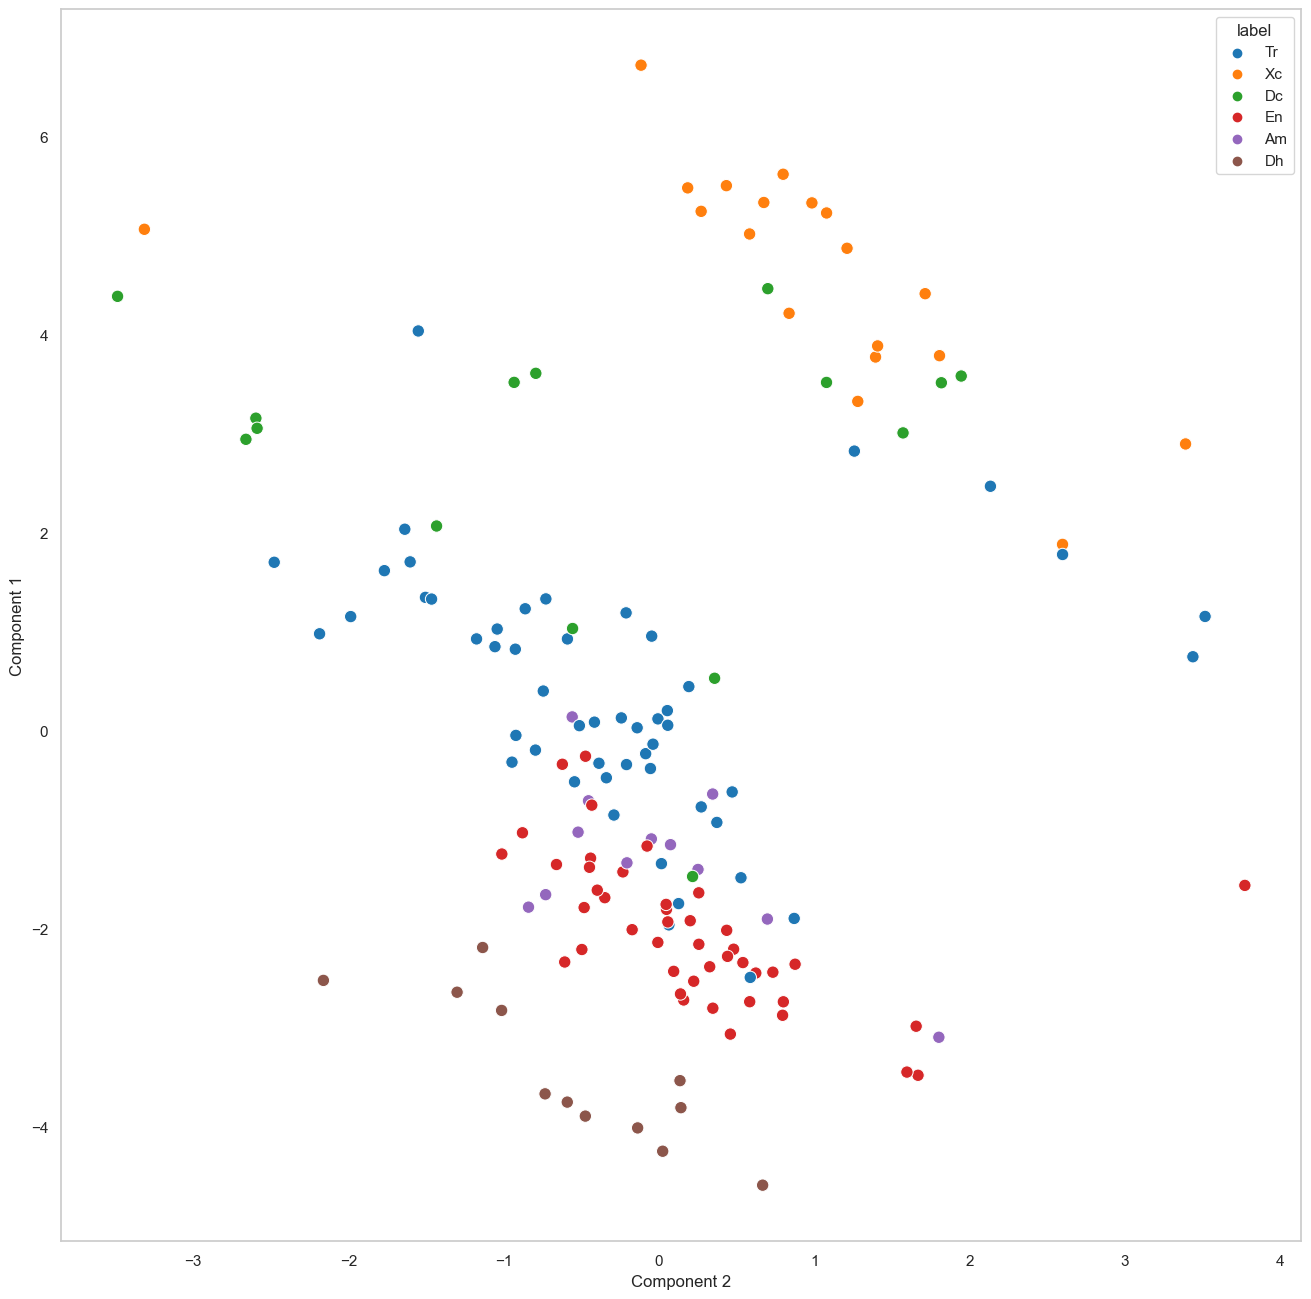

In [ ]:
#Plot actual 
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(x = x_axis,y = y_axis, hue = df.loc[:,'label'], palette = palette6, s=80)
plt.show()

# Gaussian Mixture Model

C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory le

[1704.0482493998525, 1549.1000593706954, 1436.170139777407, 1423.889869716193, 1458.5636053845324, 1457.0874777044294, 1508.0013638543664, 1463.9502355029838, 1495.9685707664848, 1502.914542070255, 1549.8405605610606, 1581.1614514887178, 1605.3317937473025, 1588.412042278197]


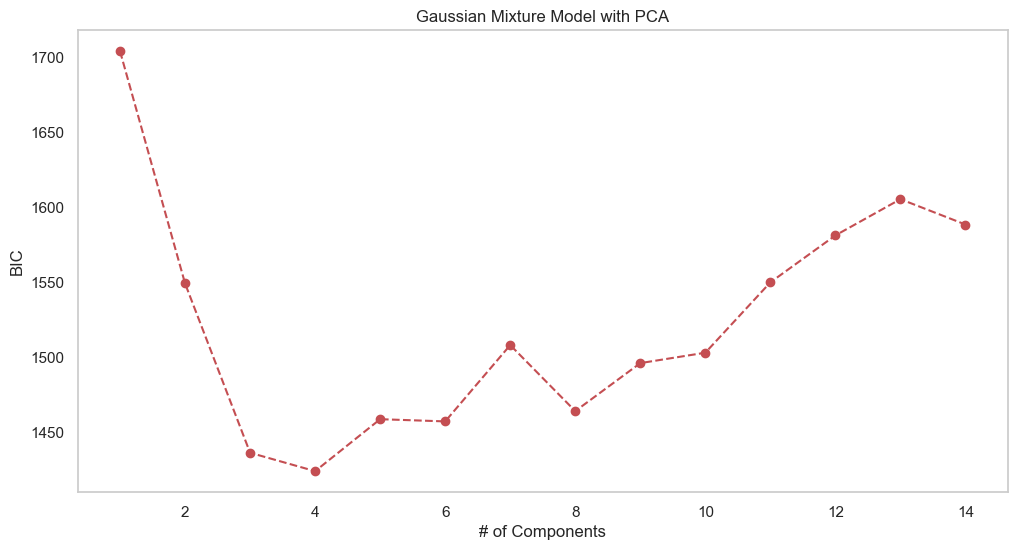

In [ ]:
bic = []
#GMM with pca for loop
for i in range (1,15):
  gmm_pca = GaussianMixture(n_components = i, random_state = 1)
  gmm_pca.fit(scores_pca)
  bic.append(gmm_pca.bic(scores_pca))

#Plot GMM performance
print(bic)
sns.set(rc={'figure.figsize':(12,6)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.plot(range(1,15), bic, marker = 'o', linestyle = '--', color = 'r')
plt.xlabel('# of Components')
plt.ylabel('BIC')
plt.title('Gaussian Mixture Model with PCA')
plt.show()

C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


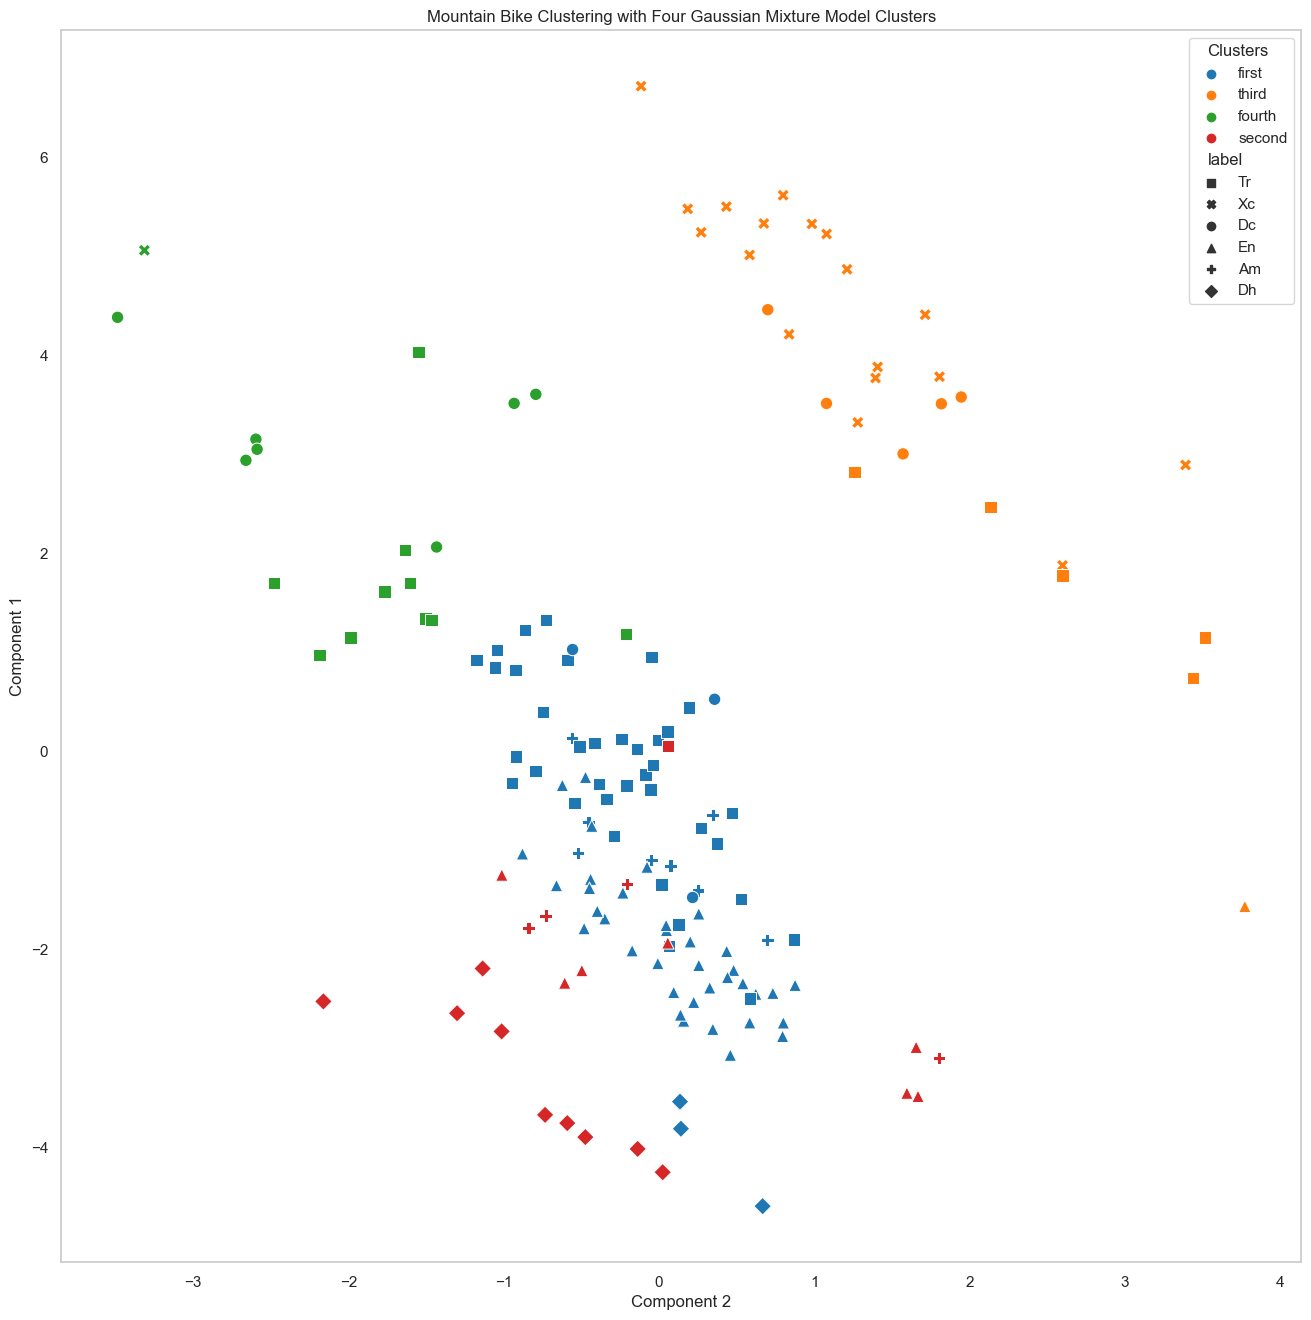

Text(0.5, 1.0, 'Mountain Bike GMM (4) Contingency Matrix')

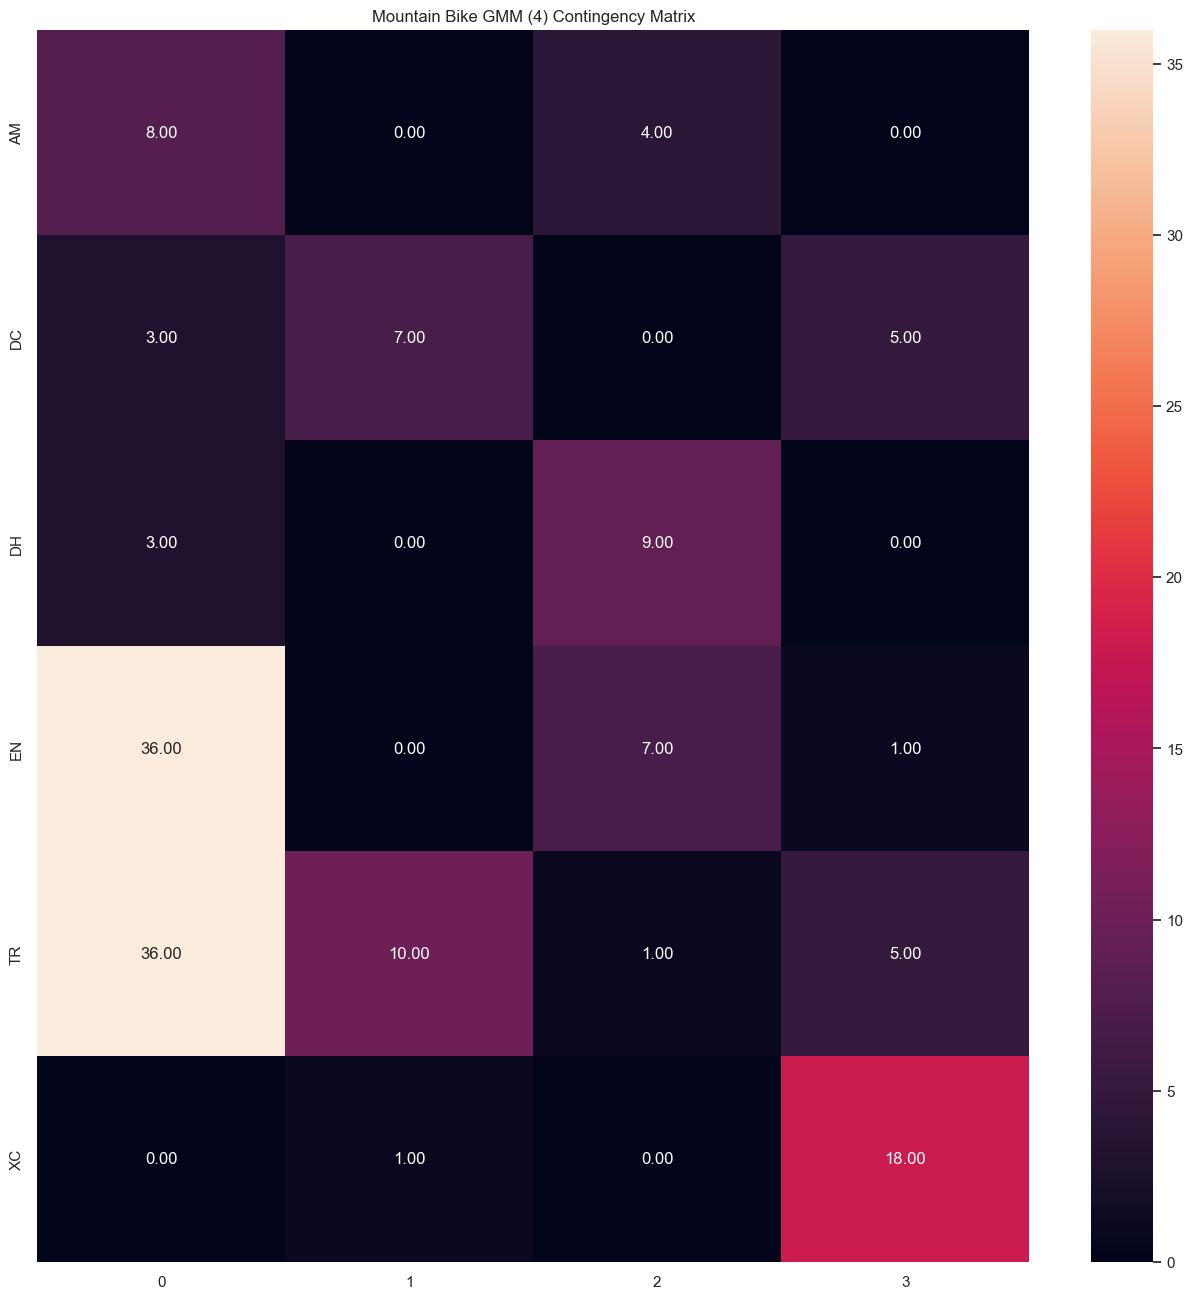

In [ ]:
#Use Four Components
gmm = GaussianMixture(n_components = 4)
gmm.fit(scores_pca)
df_pca_gmm_4 = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_gmm_4.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_pca_gmm_4['Segment K-means PCA'] = gmm.predict(scores_pca)
df_pca_gmm_4['Clusters'] = df_pca_gmm_4['Segment K-means PCA'].map({0:'first', 1:'second', 2:'third', 3:'fourth'})

#Plot four Components
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("whitegrid", {'axes.grid' : False})
palette = sns.color_palette("husl",4)
x_axis = df_pca_gmm_4['Component 2']
y_axis = df_pca_gmm_4['Component 1']
sns.scatterplot(x = x_axis,y = y_axis, hue = df_pca_gmm_4['Clusters'], palette = palette4, style = df.loc[:,'label'],s=80, markers = markers)
plt.title("Mountain Bike Clustering with Four Gaussian Mixture Model Clusters")
plt.show()

#Contingency Matrix
sns.heatmap(contingency_matrix(df.loc[:,'label'], df_pca_gmm_4['Clusters']), annot=True, fmt='.2f',yticklabels = x_ticks_labels)
plt.title("Mountain Bike GMM (4) Contingency Matrix")

C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


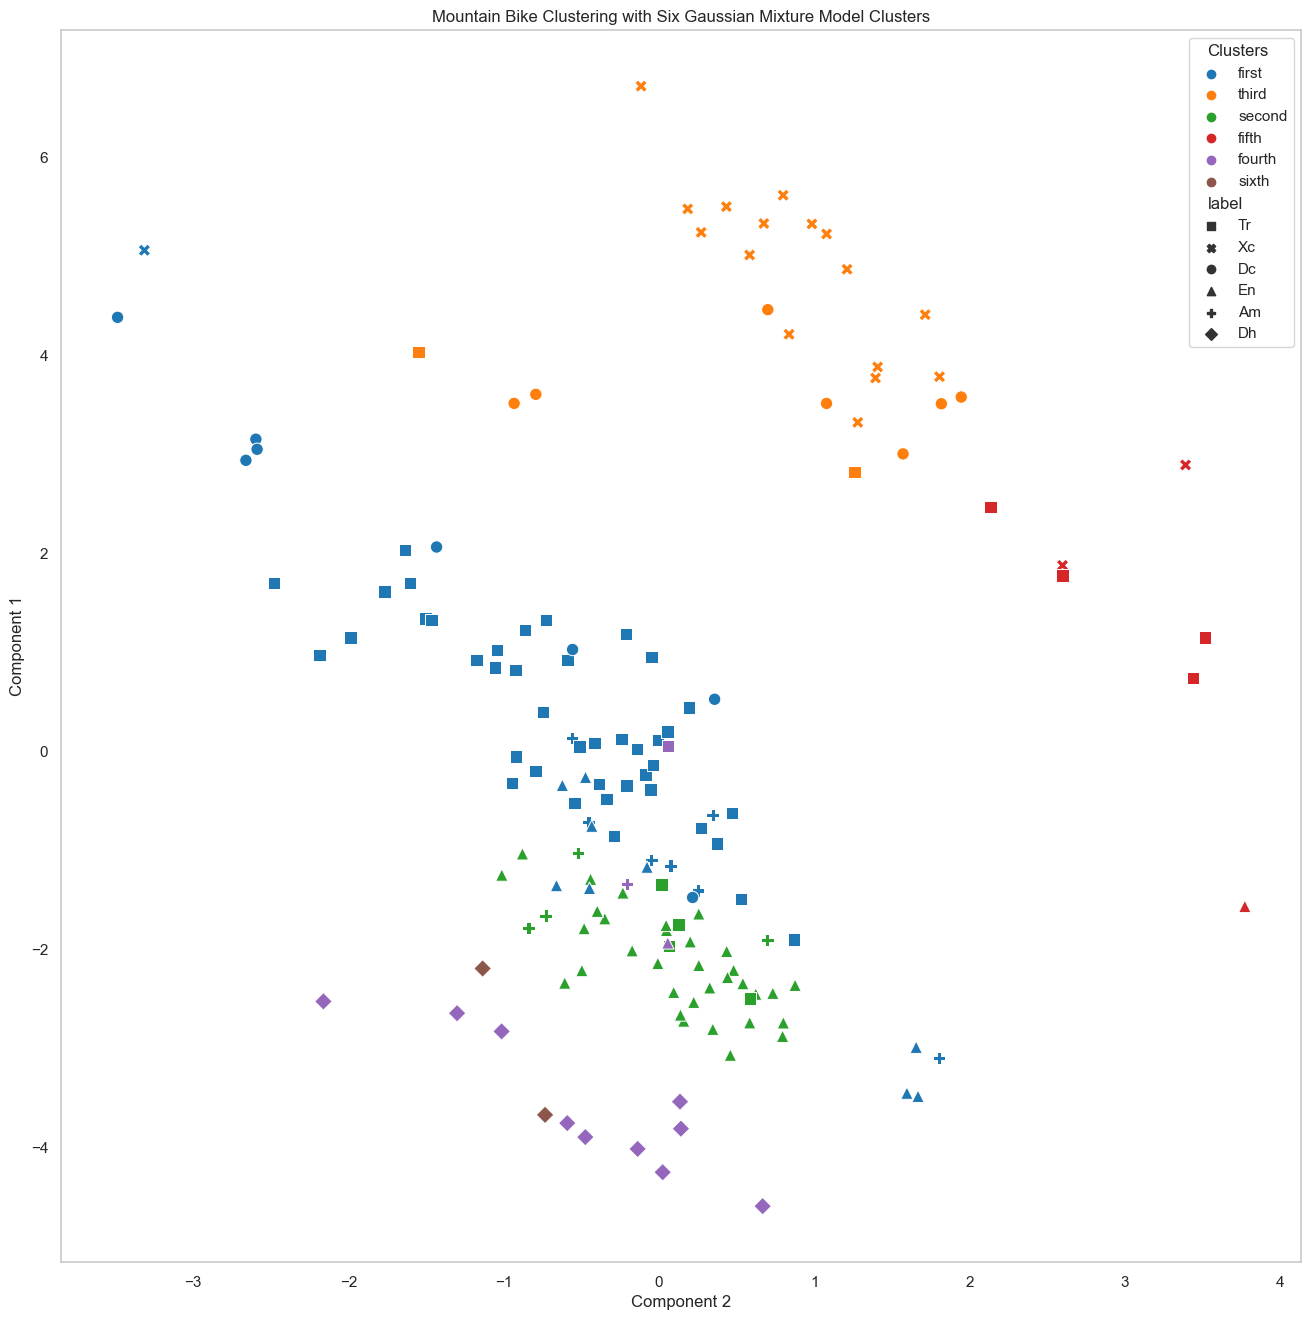

Text(0.5, 1.0, 'Mountain Bike GMM (6) Contingency Matrix')

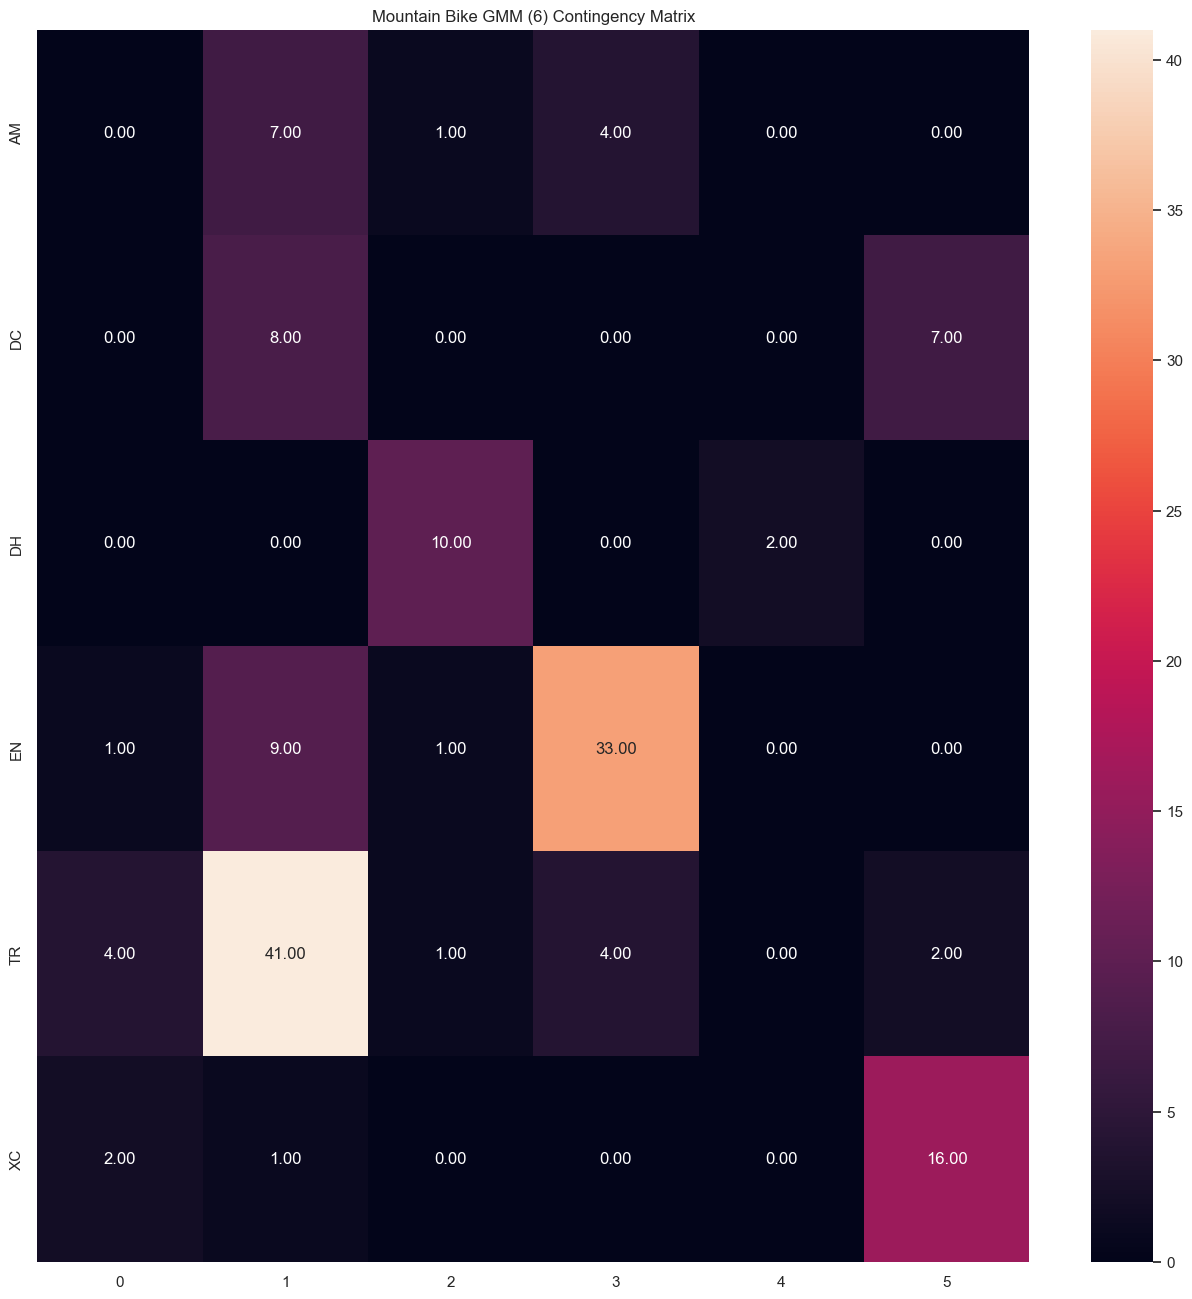

In [ ]:
#Use Six Components
gmm = GaussianMixture(n_components = 6)
gmm.fit(scores_pca)
df_pca_gmm_6 = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_gmm_6.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
df_pca_gmm_6['Segment K-means PCA'] = gmm.predict(scores_pca)
df_pca_gmm_6['Clusters'] = df_pca_gmm_6['Segment K-means PCA'].map({0:'first', 1:'second', 2:'third', 3:'fourth', 4:'fifth', 5:'sixth'})

#Plot Six Components
sns.set(rc={'figure.figsize':(16,16)})
sns.set_style("whitegrid", {'axes.grid' : False})
x_axis = df_pca_gmm_6['Component 2']
y_axis = df_pca_gmm_6['Component 1']
sns.scatterplot(x = x_axis, y = y_axis, hue = df_pca_gmm_6['Clusters'], palette=palette6, style = df.loc[:,'label'],s=80, markers = markers)
plt.title("Mountain Bike Clustering with Six Gaussian Mixture Model Clusters")
plt.show()

#Contingency Matrix
sns.heatmap(contingency_matrix(df.loc[:,'label'], df_pca_gmm_6['Clusters']), annot=True, fmt='.2f',yticklabels = x_ticks_labels)
plt.title("Mountain Bike GMM (6) Contingency Matrix")

# Random Search Classifiers


In [ ]:
# Number of trees in random forest
rf_n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
rf_max_depth.append(None)
# Minimum number of samples required to split a node
rf_min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
rf_bootstrap = [True, False]
# Create the random grid
rf_random_grid = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'max_depth': rf_max_depth,
               'min_samples_split': rf_min_samples_split,
               'min_samples_leaf': rf_min_samples_leaf,
               'bootstrap': rf_bootstrap}
#Weights
rf_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}
#Create Random Forest Classifier and Random HyperParameters Search DOUBLE RANDOM :o
rf = RandomForestClassifier(class_weight = rf_class_weight)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = rf_random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)

In [ ]:
#Regularization parameter. The strength of the regularization is inversely proportional to C
svm_regularization = [0.1, 1, 10, 100, 1000];
#Specifies the kernel type to be used in the algorithm
svm_kernel = ['poly', 'rbf', 'sigmoid'];
#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
svm_gamma = [1, 0.1, 0.01, 0.001, 0.0001];
# Create the random grid
svm_random_grid = {'C': svm_regularization, 
              'gamma': svm_gamma,
              'kernel': svm_kernel}
#Weights
svm_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}              
#Create SVM Classifier and Random HyperParameters Search
svm = SVC(class_weight = svm_class_weight)
svm_random = RandomizedSearchCV(estimator = svm, param_distributions = svm_random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)

In [ ]:
#THIS DOESN'T HAVE CLASS BALANCED
#Hidden layers and neurons
mlp_layers = [(12,6),(10,5),(8,4)];
#Activation function for the hidden layer
mlp_activation = ['tanh', 'relu'];
#The solver for weight optimization
mlp_solver = ['sgd', 'adam'];
#Strength of the L2 regularization term
mlp_alpha =  [0.0001, 0.001, 0.01];
#Learning rate schedule for weight updates
mlp_learning_rate = ['constant','invscaling','adaptive'];
# Create the random grid
mlp_random_grid = {
    'hidden_layer_sizes': mlp_layers,
    'activation': mlp_activation,
    'solver': mlp_solver,
    'alpha': mlp_alpha,
    'learning_rate': mlp_learning_rate,
}
#Create MLP Classifier and Random HyperParameters Search
mlp = MLPClassifier()
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_random_grid, n_iter = 100, cv = 3, verbose=2, random_state = 42, n_jobs = -1)

In [ ]:
#Assign X & y
X_pca = scores_pca
y = y_mean_NaN;
#Assign Split Data with 0.9 Ratio
kfold = 3
skf = StratifiedKFold(n_splits=kfold, shuffle=True,  random_state=1)
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
# Normalize Xtrain and Xtest
for i, (train_index, test_index) in enumerate(skf.split(X_pca_scaled, y)):
    # Split the data
    print('[Fold %d/%d]' % (i + 1, kfold))
    x_train_fold_pca, x_test_fold_pca = X_pca_scaled[train_index], X_pca_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    # Fit our train data
    rf_random.fit(x_train_fold_pca, y_train_fold)
    svm_random.fit(x_train_fold_pca, y_train_fold)
    mlp_random.fit(x_train_fold_pca, y_train_fold)
    print('RF best parameters found:\n', rf_random.best_params_)
    print('SVM best parameters found:\n', svm_random.best_params_)
    print('MLP best parameters found:\n', mlp_random.best_params_)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    rf_pred_train = rf_random.predict(x_train_fold_pca)
    rf_pred_test = rf_random.predict(x_test_fold_pca)
    svm_pred_train = svm_random.predict(x_train_fold_pca)
    svm_pred_test = svm_random.predict(x_test_fold_pca)
    mlp_pred_train = mlp_random.predict(x_train_fold_pca)
    mlp_pred_test = mlp_random.predict(x_test_fold_pca)
    #Check f1 score on train/test data
    rf_train_f1 = f1_score(y_train_fold, rf_pred_train, average='weighted')
    rf_test_f1 = f1_score(y_test_fold, rf_pred_test, average='weighted')
    svm_train_f1 = f1_score(y_train_fold, svm_pred_train, average='weighted')
    svm_test_f1 = f1_score(y_test_fold, svm_pred_test, average='weighted')
    mlp_train_f1 = f1_score(y_train_fold, mlp_pred_train, average='weighted')
    mlp_test_f1 = f1_score(y_test_fold, mlp_pred_test, average='weighted')
    print("RF train f1 score on train data: ", rf_train_f1)
    print("RF test f1 score on test data: ", rf_test_f1)
    print("SVM train f1 score on train data: ", svm_train_f1)
    print("SVM test f1 score on test data: ", svm_test_f1)
    print("MLP train f1 score on train data: ", mlp_train_f1)
    print("MLP test f1 score on test data: ", mlp_test_f1)

[Fold 1/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
SVM best parameters found:
 {'kernel': 'rbf', 'gamma': 1, 'C': 10}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (12, 6), 'alpha': 0.0001, 'activation': 'tanh'}
[Fold 1/3 Prediciton:]
RF train f1 score on train data:  0.9705557849459477
RF test f1 score on test data:  0.6293079680176454
SVM train f1 score on train data:  0.8048060149707117
SVM test f1 score on test data:  0.6005221823477401
MLP train f1 score on train data:  0.39912518853695333
MLP test f1 score on test data:  0.3736755965199414
[Fold 2/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
SVM best parameters found:
 {'kernel': 'rbf', 'gamma': 0.1, 'C': 1000}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (12, 6), 'alpha': 0.001, 'activation': 'tanh'}
[Fold 2/3 Prediciton:]
RF train f1 score on train data:  0.867389688453829
RF test f1 score on test data:  0.7555177243311118
SVM train f1 score on train data:  0.8197273962101342
SVM test f1 score on test data:  0.7662210338680927
MLP train f1 score on train data:  0.48566568826672685
MLP test f1 score on test data:  0.5559683522531819
[Fold 3/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
RF best parameters found:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
SVM best parameters found:
 {'kernel': 'sigmoid', 'gamma': 0.1, 'C': 1000}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (12, 6), 'alpha': 0.01, 'activation': 'tanh'}
[Fold 3/3 Prediciton:]
RF train f1 score on train data:  1.0
RF test f1 score on test data:  0.7207004596710479
SVM train f1 score on train data:  0.7538079461101861
SVM test f1 score on test data:  0.7882963704464717
MLP train f1 score on train data:  0.3688624746695703
MLP test f1 score on test data:  0.37412783295136237


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# WITHOUT PCA
#Assign X & y
X_df = df[df.columns[3:-1]].values
y = y_mean_NaN;
#Assign Split Data with 0.9 Ratio
kfold = 3
skf = StratifiedKFold(n_splits=kfold, shuffle=True,  random_state=1)
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
X_df_scaled = scaler.fit_transform(X_df)
# Normalize Xtrain and Xtest
for i, (train_index, test_index) in enumerate(skf.split(X_df, y)):
    # Split the data
    print('[Fold %d/%d]' % (i + 1, kfold))
    x_train_fold, x_test_fold = X_df[train_index], X_df[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    # Fit our train data
    rf_random.fit(x_train_fold, y_train_fold)
    svm_random.fit(x_train_fold, y_train_fold)
    mlp_random.fit(x_train_fold, y_train_fold)
    print('RF best parameters found:\n', rf_random.best_params_)
    print('SVM best parameters found:\n', svm_random.best_params_)
    print('MLP best parameters found:\n', mlp_random.best_params_)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    rf_pred_train = rf_random.predict(x_train_fold)
    rf_pred_test = rf_random.predict(x_test_fold)
    svm_pred_train = svm_random.predict(x_train_fold)
    svm_pred_test = svm_random.predict(x_test_fold)
    mlp_pred_train = mlp_random.predict(x_train_fold)
    mlp_pred_test = mlp_random.predict(x_test_fold)
    #Check f1 score on train/test data
    rf_train_f1 = f1_score(y_train_fold, rf_pred_train, average='weighted')
    rf_test_f1 = f1_score(y_test_fold, rf_pred_test, average='weighted')
    svm_train_f1 = f1_score(y_train_fold, svm_pred_train, average='weighted')
    svm_test_f1 = f1_score(y_test_fold, svm_pred_test, average='weighted')
    mlp_train_f1 = f1_score(y_train_fold, mlp_pred_train, average='weighted')
    mlp_test_f1 = f1_score(y_test_fold, mlp_pred_test, average='weighted')
    print("RF train f1 score on train data: ", rf_train_f1)
    print("RF test f1 score on test data: ", rf_test_f1)
    print("SVM train f1 score on train data: ", svm_train_f1)
    print("SVM test f1 score on test data: ", svm_test_f1)
    print("MLP train f1 score on train data: ", mlp_train_f1)
    print("MLP test f1 score on test data: ", mlp_test_f1)

[Fold 1/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.5s finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
SVM best parameters found:
 {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (12, 6), 'alpha': 0.01, 'activation': 'tanh'}
[Fold 1/3 Prediciton:]
RF train f1 score on train data:  0.9804218657159833
RF test f1 score on test data:  0.6386349761349762
SVM train f1 score on train data:  1.0
SVM test f1 score on test data:  0.6946467381873709
MLP train f1 score on train data:  0.39079512401975713
MLP test f1 score on test data:  0.3393100801637387
[Fold 2/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    0.1s finished


Fitting 3 folds for each of 75 candidates, totalling 225 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.7s finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


RF best parameters found:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
SVM best parameters found:
 {'kernel': 'poly', 'gamma': 1, 'C': 0.1}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 5), 'alpha': 0.001, 'activation': 'tanh'}
[Fold 2/3 Prediciton:]
RF train f1 score on train data:  1.0
RF test f1 score on test data:  0.6990122364735367
SVM train f1 score on train data:  0.990036008933862
SVM test f1 score on test data:  0.6580790306280503
MLP train f1 score on train data:  0.2842520616284445
MLP test f1 score on test data:  0.3094925315039167
[Fold 3/3]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 75 is smaller than n_iter=100. Running 75 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    2.4s


# Grid Search Classifiers


In [ ]:
# Number of trees in random forest
rf_n_estimators = [int(x) for x in np.linspace(start = 1500, stop = 1700, num = 50)]
# Number of features to consider at every split
rf_max_features = ['sqrt']
# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
rf_max_depth.append(None)
# Minimum number of samples required to split a node
rf_min_samples_split = [5,4]
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = [2, 4]
# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'max_depth': rf_max_depth,
               'min_samples_split': rf_min_samples_split,
               'min_samples_leaf': rf_min_samples_leaf,
               }
#Weights
rf_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}
#Create Random Forest Classifier and Grid HyperParameters Search
rf = RandomForestClassifier(class_weight = rf_class_weight)
rf_random = GridSearchCV(estimator = rf, param_grid = rf_grid, cv = 3, verbose=3, n_jobs = -1)

In [ ]:
#Regularization parameter. The strength of the regularization is inversely proportional to C
svm_regularization = [800, 1000, 1200];
#Specifies the kernel type to be used in the algorithm
svm_kernel = ['rbf', 'sigmoid'];
#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
svm_gamma = [0.08, 0.1, 0.12];
# Create the grid
svm_grid = {'C': svm_regularization, 
              'gamma': svm_gamma,
              'kernel': svm_kernel}
#Weights
svm_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}              
#Create SVM Classifier and Random HyperParameters Search
svm = SVC(class_weight = svm_class_weight)
svm_random = GridSearchCV(estimator = svm, param_grid = svm_grid, cv = 3, verbose=3, n_jobs = -1)

In [ ]:
#THIS DOESN'T HAVE CLASS BALANCED
#Hidden layers and neurons
mlp_layers = [(10,5),(9,5),(9,4),(8,4)];
#Activation function for the hidden layer
mlp_activation = ['tanh'];
#The solver for weight optimization
mlp_solver = ['adam'];
#Strength of the L2 regularization term
mlp_alpha =  [0.0001, 0.001, 0.01];
#Learning rate schedule for weight updates
mlp_learning_rate = ['constant','invscaling'];
# Create the random grid
mlp_random_grid = {
    'hidden_layer_sizes': mlp_layers,
    'activation': mlp_activation,
    'solver': mlp_solver,
    'alpha': mlp_alpha,
    'learning_rate': mlp_learning_rate,
}
#Create MLP Classifier and Random HyperParameters Search
mlp = MLPClassifier()
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_random_grid, cv = 3, verbose=3, n_jobs = -1)

In [ ]:
#Assign X & y
X_pca = scores_pca
y = y_mean_NaN;
#Assign Split Data with 0.9 Ratio
kfold = 3
skf = StratifiedKFold(n_splits=kfold, shuffle=True,  random_state=1)
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
# Normalize Xtrain and Xtest
for i, (train_index, test_index) in enumerate(skf.split(X_pca_scaled, y)):
    # Split the data
    print('[Fold %d/%d]' % (i + 1, kfold))
    x_train_fold_pca, x_test_fold_pca = X_pca_scaled[train_index], X_pca_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    # Fit our train data
    rf_random.fit(x_train_fold_pca, y_train_fold)
    svm_random.fit(x_train_fold_pca, y_train_fold)
    mlp_random.fit(x_train_fold_pca, y_train_fold)
    print('RF best parameters found:\n', rf_random.best_params_)
    print('SVM best parameters found:\n', svm_random.best_params_)
    print('MLP best parameters found:\n', mlp_random.best_params_)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    rf_pred_train = rf_random.predict(x_train_fold_pca)
    rf_pred_test = rf_random.predict(x_test_fold_pca)
    svm_pred_train = svm_random.predict(x_train_fold_pca)
    svm_pred_test = svm_random.predict(x_test_fold_pca)
    mlp_pred_train = mlp_random.predict(x_train_fold_pca)
    mlp_pred_test = mlp_random.predict(x_test_fold_pca)
    #Check f1 score on train/test data
    rf_train_f1 = f1_score(y_train_fold, rf_pred_train, average='weighted')
    rf_test_f1 = f1_score(y_test_fold, rf_pred_test, average='weighted')
    svm_train_f1 = f1_score(y_train_fold, svm_pred_train, average='weighted')
    svm_test_f1 = f1_score(y_test_fold, svm_pred_test, average='weighted')
    mlp_train_f1 = f1_score(y_train_fold, mlp_pred_train, average='weighted')
    mlp_test_f1 = f1_score(y_test_fold, mlp_pred_test, average='weighted')
    print("RF train f1 score on train data: ", rf_train_f1)
    print("RF test f1 score on test data: ", rf_test_f1)
    print("SVM train f1 score on train data: ", svm_train_f1)
    print("SVM test f1 score on test data: ", svm_test_f1)
    print("MLP train f1 score on train data: ", mlp_train_f1)
    print("MLP test f1 score on test data: ", mlp_test_f1)

[Fold 1/3]
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 19.8min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1610}
SVM best parameters found:
 {'C': 1000, 'gamma': 0.08, 'kernel': 'rbf'}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (9, 5), 'alpha': 0.0001, 'activation': 'tanh'}
[Fold 1/3 Prediciton:]
RF train f1 score on train data:  0.9505516040838994
RF test f1 score on test data:  0.6149619611158073
SVM train f1 score on train data:  0.825685842651787
SVM test f1 score on test data:  0.5630566391012638
MLP train f1 score on train data:  0.47787114845938367
MLP test f1 score on test data:  0.4113452337136548
[Fold 2/3]
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 19.9min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1602}
SVM best parameters found:
 {'C': 800, 'gamma': 0.12, 'kernel': 'rbf'}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 5), 'alpha': 0.001, 'activation': 'tanh'}
[Fold 2/3 Prediciton:]
RF train f1 score on train data:  0.8671815257980607
RF test f1 score on test data:  0.7555177243311118
SVM train f1 score on train data:  0.8197273962101342
SVM test f1 score on test data:  0.7473394071433287
MLP train f1 score on train data:  0.1723652736738427
MLP test f1 score on test data:  0.16666666666666666
[Fold 3/3]
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1140 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 2036 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3188 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 20.0min finished


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RF best parameters found:
 {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 1675}
SVM best parameters found:
 {'C': 1000, 'gamma': 0.12, 'kernel': 'sigmoid'}
MLP best parameters found:
 {'solver': 'adam', 'learning_rate': 'constant', 'hidden_layer_sizes': (9, 4), 'alpha': 0.0001, 'activation': 'tanh'}
[Fold 3/3 Prediciton:]
RF train f1 score on train data:  0.9709016731589789
RF test f1 score on test data:  0.7586906557494794
SVM train f1 score on train data:  0.7420913438204553
SVM test f1 score on test data:  0.8019692725575079
MLP train f1 score on train data:  0.1723652736738427
MLP test f1 score on test data:  0.16666666666666666


# Final Hyperparameters

In [ ]:
# Number of trees in random forest
rf_n_estimators = 1000
# Number of features to consider at every split
rf_max_features = 'sqrt'
# Maximum number of levels in tree
rf_max_depth = 20
# Minimum number of samples required to split a node
rf_min_samples_split = 4
# Minimum number of samples required at each leaf node
rf_min_samples_leaf = 4
#Weights
rf_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}
#Create Random Forest Classifier
rf = RandomForestClassifier(class_weight = rf_class_weight, n_estimators=rf_n_estimators,max_features=rf_max_features,max_depth=rf_max_depth,min_samples_split=rf_min_samples_split,min_samples_leaf=rf_min_samples_leaf)

In [ ]:
#Regularization parameter. The strength of the regularization is inversely proportional to C
svm_regularization = 1000;
#Specifies the kernel type to be used in the algorithm
svm_kernel = 'sigmoid';
#Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
svm_gamma = 0.12;
#Weights
svm_class_weight = {0: 154/12, 1: 154/15, 2: 154/12, 3: 154/44, 4: 154/52, 5: 154/19}              
#Create SVM Classifier
svm = SVC(class_weight = svm_class_weight,kernel=svm_kernel,gamma=svm_gamma,C=svm_regularization)

In [ ]:
#THIS DOESN'T HAVE CLASS BALANCED
#Hidden layers and neurons
mlp_layers = (9,5);
#Activation function for the hidden layer
mlp_activation = 'tanh';
#The solver for weight optimization
mlp_solver = 'adam';
#Strength of the L2 regularization term
mlp_alpha =  0.0001;
#Learning rate schedule for weight updates
mlp_learning_rate = 'constant';
#Create MLP Classifier and Random HyperParameters Search
mlp = MLPClassifier(hidden_layer_sizes=mlp_layers, activation=mlp_activation,solver=mlp_solver,alpha=mlp_alpha,learning_rate=mlp_learning_rate)

[Fold 1/3]


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 1/3 Prediciton:]
RF test f1 score on test data:  0.6145313572369275
SVM test f1 score on test data:  0.6256796332081087
MLP test f1 score on test data:  0.3802028176245948


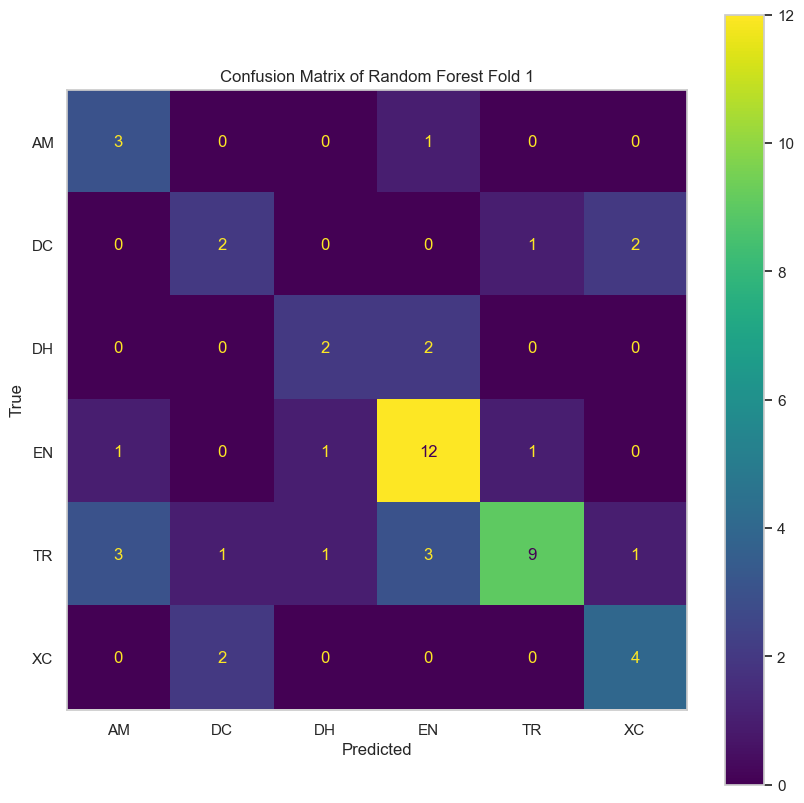

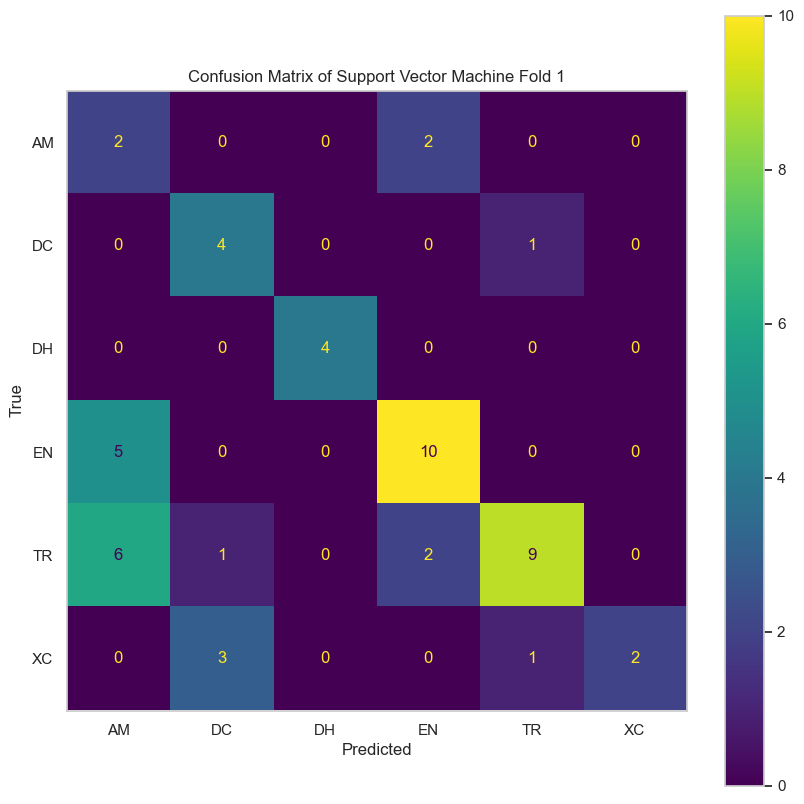

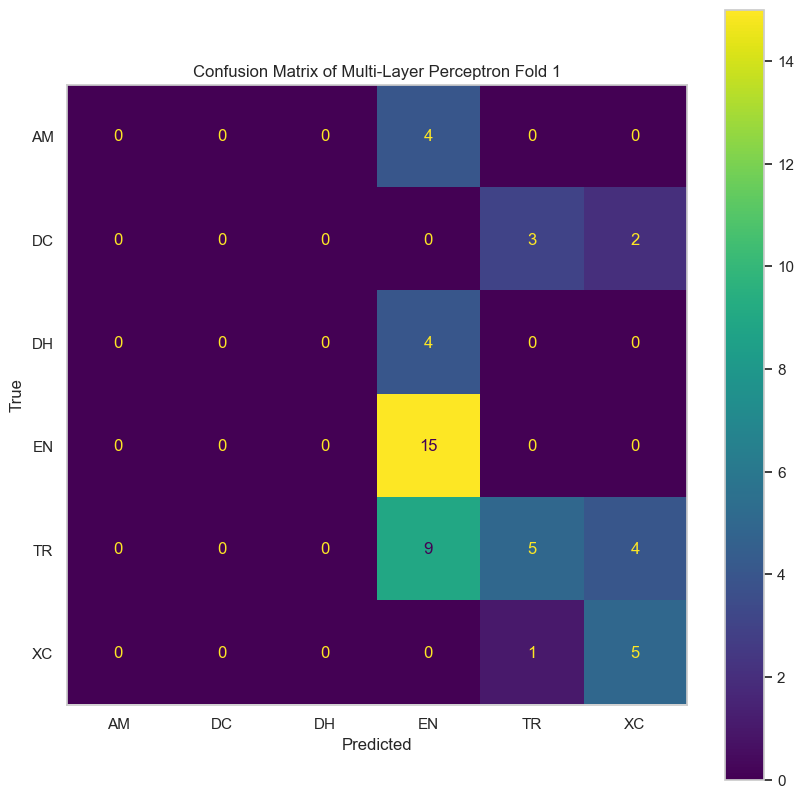

[Fold 2/3]


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 2/3 Prediciton:]
RF test f1 score on test data:  0.7555177243311118
SVM test f1 score on test data:  0.7487291212781408
MLP test f1 score on test data:  0.4010012515644556


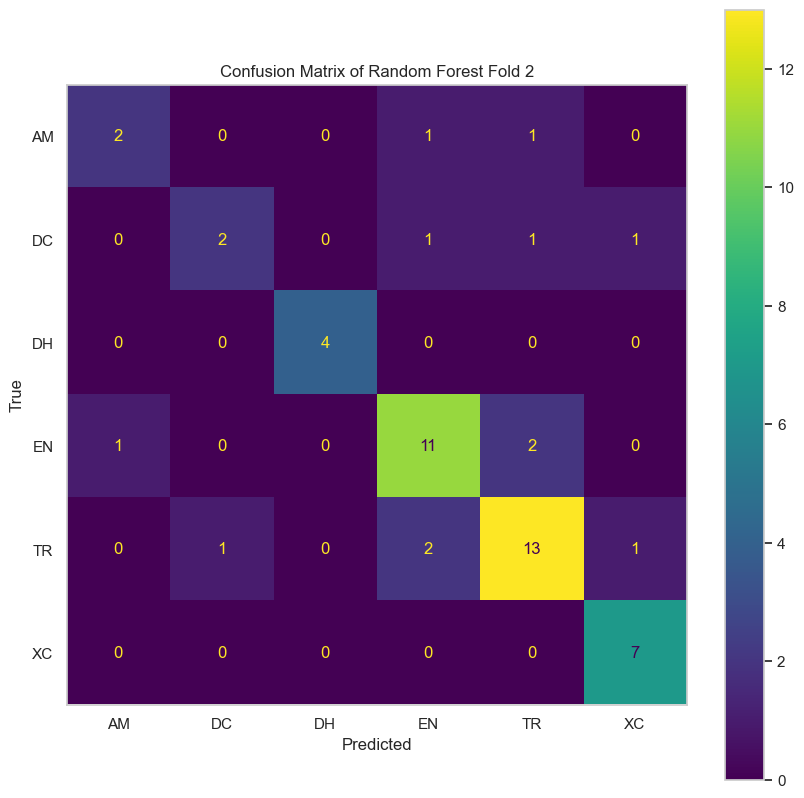

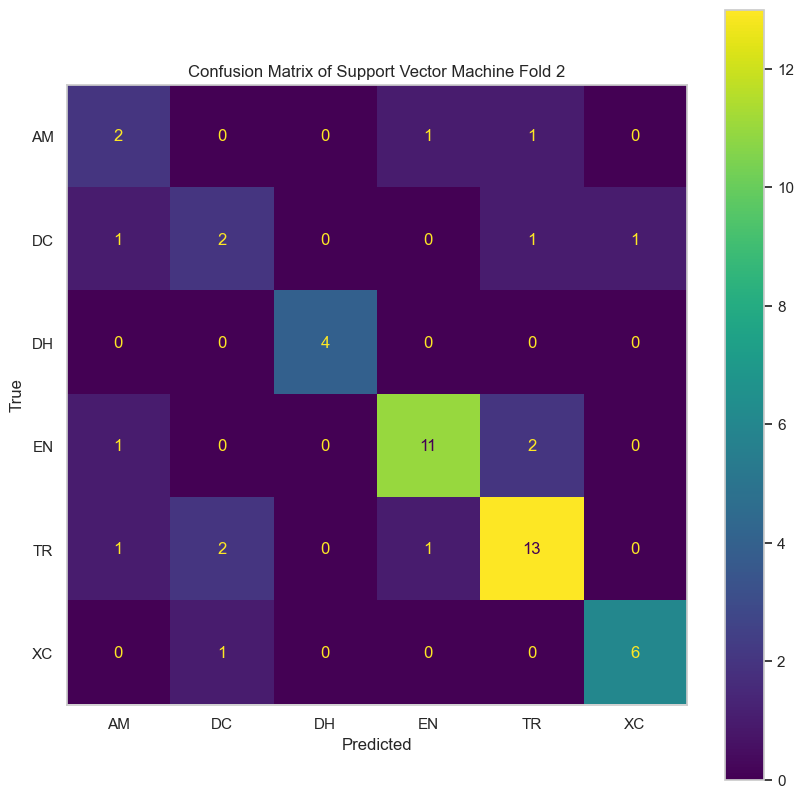

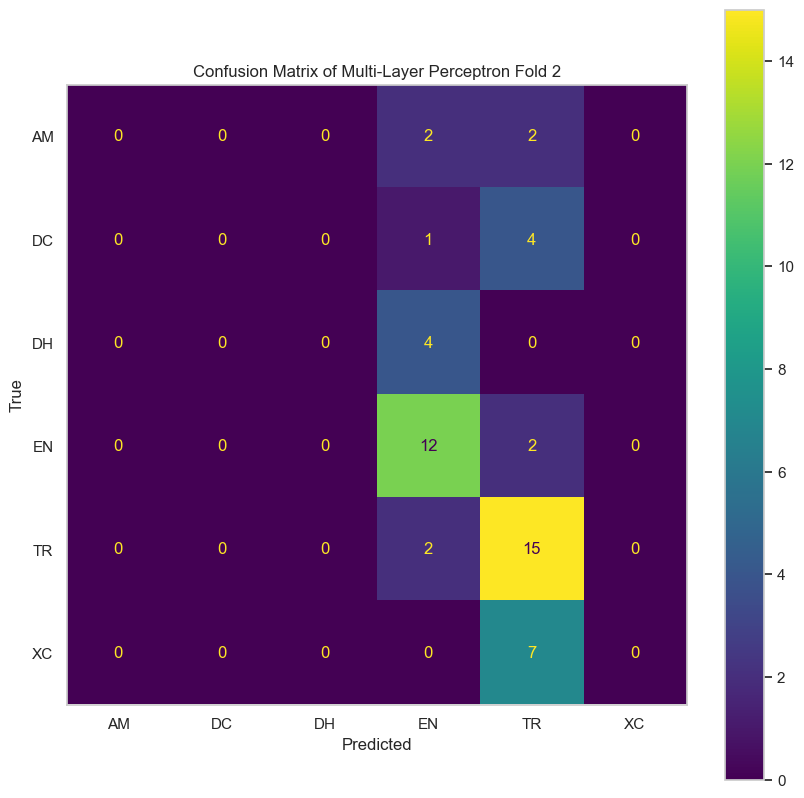

[Fold 3/3]


C:\Users\idhelman\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[Fold 3/3 Prediciton:]
RF test f1 score on test data:  0.7172102557498095
SVM test f1 score on test data:  0.8019692725575079
MLP test f1 score on test data:  0.20926614097102628


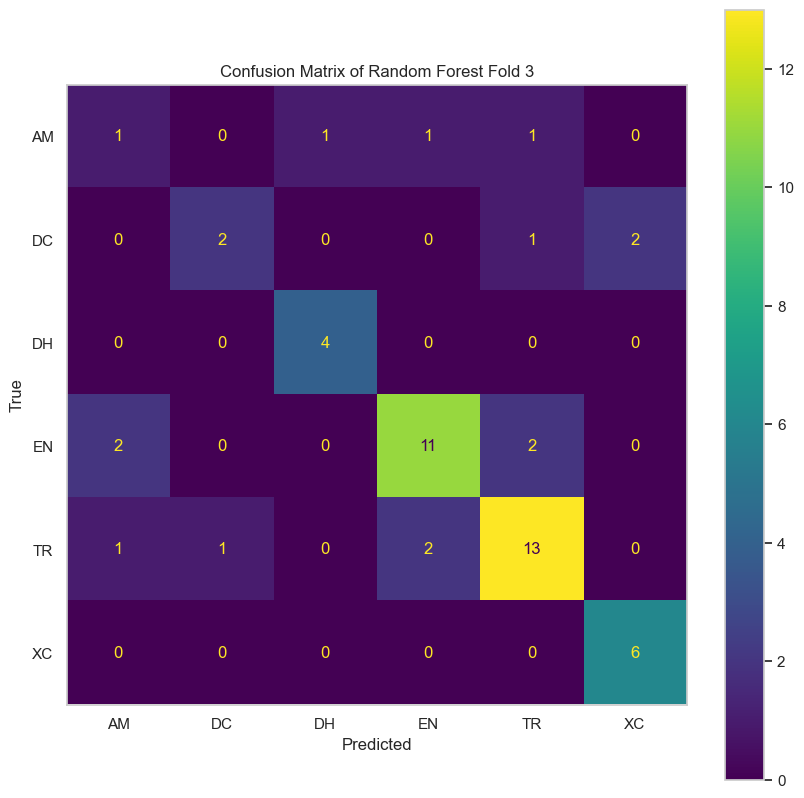

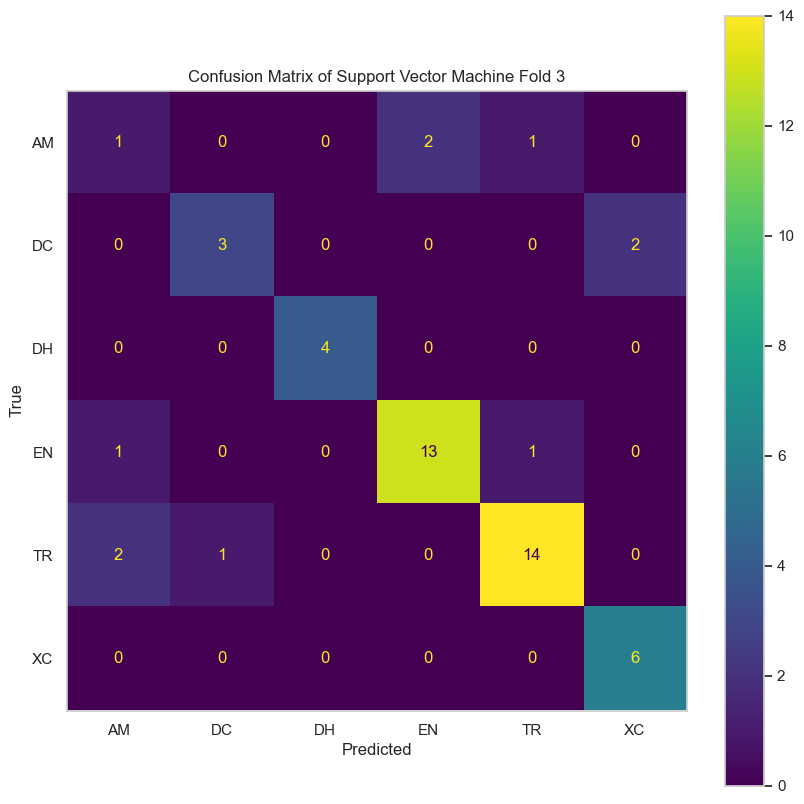

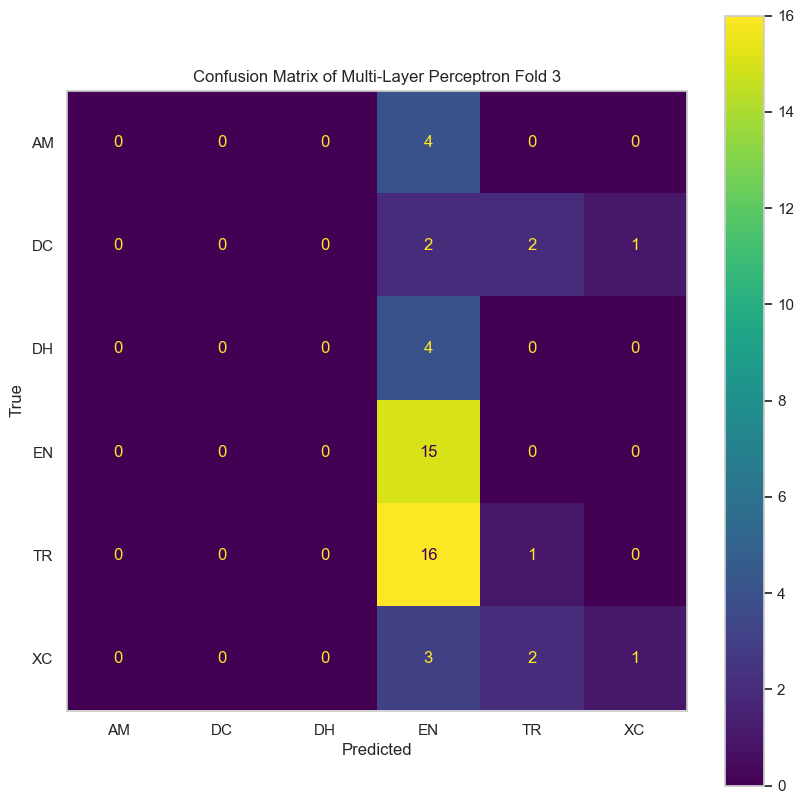

In [ ]:
#Assign X & y
X_pca = scores_pca
y = y_mean_NaN;
#Assign Split Data with 0.9 Ratio
kfold = 3
skf = StratifiedKFold(n_splits=kfold, shuffle=True,  random_state=1)
# Feature Scaling for input features.
scaler = preprocessing.MinMaxScaler()
X_pca_scaled = scaler.fit_transform(X_pca)
A = np.array([1, 2, 3])
# F1 Means
rf_mean_f1 = 0;
svm_mean_f1 = 0;
mlp_mean_f1 = 0;
# Normalize Xtrain and Xtest
for i, (train_index, test_index) in enumerate(skf.split(X_pca_scaled, y)):
    # Split the data
    print('[Fold %d/%d]' % (i + 1, kfold))
    x_train_fold_pca, x_test_fold_pca = X_pca_scaled[train_index], X_pca_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    # Fit our train data
    rf.fit(x_train_fold_pca, y_train_fold)
    svm.fit(x_train_fold_pca, y_train_fold)
    mlp.fit(x_train_fold_pca, y_train_fold)
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    # Predict on our test data
    rf_pred_test = rf.predict(x_test_fold_pca)
    svm_pred_test = svm.predict(x_test_fold_pca)
    mlp_pred_test = mlp.predict(x_test_fold_pca)
    #Check f1 score on train/test data
    rf_test_f1 = f1_score(y_test_fold, rf_pred_test, average='weighted')
    svm_test_f1 = f1_score(y_test_fold, svm_pred_test, average='weighted')
    mlp_test_f1 = f1_score(y_test_fold, mlp_pred_test, average='weighted')
    print("RF test f1 score on test data: ", rf_test_f1)
    print("SVM test f1 score on test data: ", svm_test_f1)
    print("MLP test f1 score on test data: ", mlp_test_f1)  
    rf_mean_f1 = rf_test_f1 + rf_mean_f1;
    svm_mean_f1 = svm_test_f1 + svm_mean_f1;
    mlp_mean_f1 = mlp_test_f1 + mlp_mean_f1;
    #Plot Confusion Matrix
    confusion_matrix_rf = confusion_matrix(y_test_fold, rf_pred_test)
    cmp = ConfusionMatrixDisplay(confusion_matrix_rf,display_labels=x_ticks_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix of Random Forest Fold ' + str((i + 1)))
    cmp.plot(ax=ax)    
    cmp.ax_.set(xlabel='Predicted', ylabel='True')
    confusion_matrix_svm = confusion_matrix(y_test_fold, svm_pred_test)
    cmp = ConfusionMatrixDisplay(confusion_matrix_svm,display_labels=x_ticks_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix of Support Vector Machine Fold ' + str((i + 1)))
    cmp.plot(ax=ax)
    cmp.ax_.set(xlabel='Predicted', ylabel='True')
    confusion_matrix_mlp = confusion_matrix(y_test_fold, mlp_pred_test)
    cmp = ConfusionMatrixDisplay(confusion_matrix_mlp,display_labels=x_ticks_labels)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title('Confusion Matrix of Multi-Layer Perceptron Fold ' + str((i + 1)))
    cmp.plot(ax=ax)
    cmp.ax_.set(xlabel='Predicted', ylabel='True')
    plt.show()

rf_mean_f1 = rf_mean_f1/3;
svm_mean_f1 = svm_mean_f1/3;
mlp_mean_f1 = mlp_mean_f1/3;
clf_mean_f1 = [rf_mean_f1,svm_mean_f1,mlp_mean_f1]

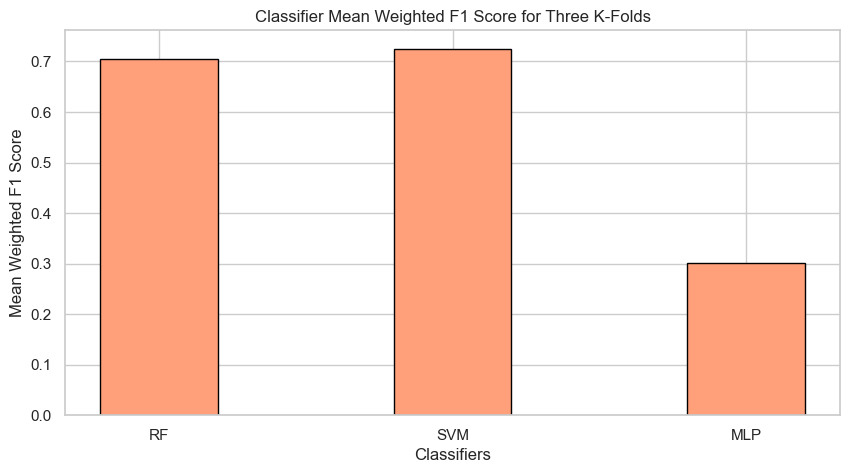

In [ ]:
fig = plt.figure(figsize = (10, 5))
keys = ["RF","SVM","MLP"]
# creating the bar plot
plt.bar(keys, clf_mean_f1, facecolor='lightsalmon',edgecolor='black', width = 0.4)
 
plt.xlabel("Classifiers")
plt.ylabel("Mean Weighted F1 Score")
plt.title("Classifier Mean Weighted F1 Score for Three K-Folds")
plt.grid()
plt.show()

In [ ]:
print(x_train_fold_pca.shape)

(102, 3)
